### Prediction And Forecasting Using Stacked LSTM

In [1]:
# https://github.com/krishnaik06/Stock-MArket-Forecasting
# https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

In [2]:
!pip install pandas_datareader
!pip install keras
!pip install tensorflow
!pip3 install --upgrade tensorflow
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 107 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 9.3 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.0
    Uninstalling scipy-1.5.0:
      Successfully uninstalled scipy-1.5.0
     |████████████████████████████████| 394.7 MB 25 kB/s s eta 0:00:01
     |████████████████████████████████| 10.6 MB 41.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.4 MB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 43.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 38.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 7.7 MB/s  eta 0:00:01
     |████████████████████████████████| 14.8 MB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 40.5 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.27.2
    Uninstall

In [3]:
### Data Collection
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
#tf.__version__
from keras.layers import Bidirectional


In [4]:
#!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf

In [5]:
startdt=pd.to_datetime('2012-01-01')
enddt = pd.to_datetime('2021-01-18')
days=len(pd.date_range(start=startdt,end=enddt,freq='D'))

In [6]:
#most IBOV tickets (updated in mid-2020)
tickers_ibov = "ABEV3.SA AZUL4.SA B3SA3.SA BBAS3.SA BBDC3.SA BBDC4.SA BBSE3.SA BPAC11.SA BRAP4.SA BRDT3.SA BRFS3.SA BRKM5.SA BRML3.SA BTOW3.SA CCRO3.SA CIEL3.SA CMIG4.SA COGN3.SA CRFB3.SA CSAN3.SA CSNA3.SA CVCB3.SA CYRE3.SA ECOR3.SA EGIE3.SA ELET3.SA ELET6.SA EMBR3.SA ENBR3.SA EQTL3.SA FLRY3.SA GGBR4.SA GNDI3.SA GOAU4.SA GOLL4.SA HAPV3.SA HGTX3.SA HYPE3.SA IGTA3.SA IRBR3.SA ITSA4.SA ITUB4.SA JBSS3.SA KLBN11.SA LAME4.SA LREN3.SA MGLU3.SA MRFG3.SA MRVE3.SA MULT3.SA NTCO3.SA PCAR3.SA PETR3.SA PETR4.SA QUAL3.SA RADL3.SA RAIL3.SA RENT3.SA SANB11.SA SBSP3.SA SMLS3.SA SULA11.SA SUZB3.SA TAEE11.SA TIMP3.SA TOTS3.SA UGPA3.SA USIM5.SA VALE3.SA VIVT4.SA VVAR3.SA WEGE3.SA YDUQ3.SA"
#ibov = yf.download(tickers=tickers_ibov,start=startdt,end=enddt)["Adj Close"]
df = yf.download(tickers='PETR4.SA',start=startdt,end=enddt)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [7]:
df.head()

Date
2012-01-02    18.554081
2012-01-03    19.134697
2012-01-04    19.271320
2012-01-05    19.049313
2012-01-06    19.066393
Name: Adj Close, dtype: float64

In [8]:
df.shape

(2235,)

In [9]:
df.dropna
df.shape

(2235,)

In [10]:
df0=df.reset_index()
df0.head()

,Date,Adj Close
0,2012-01-02,18.554081
1,2012-01-03,19.134697
2,2012-01-04,19.271320
3,2012-01-05,19.049313
4,2012-01-06,19.066393


In [11]:
df1=df0['Adj Close']
df1.head()

0    18.554081
1    19.134697
2    19.271320
3    19.049313
4    19.066393
Name: Adj Close, dtype: float64

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

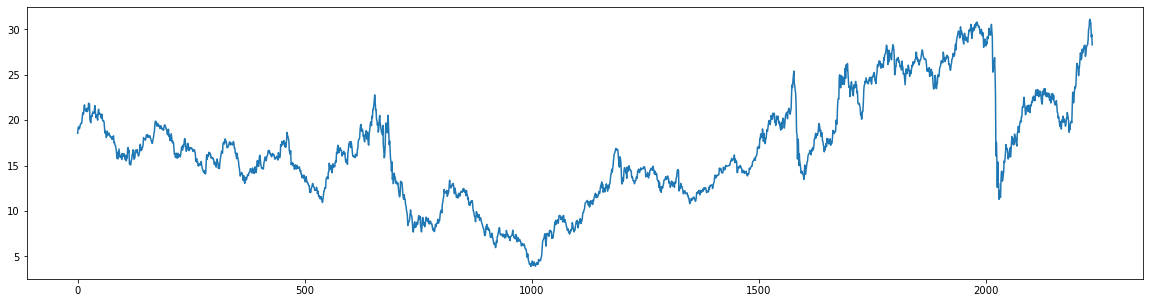

In [12]:
#plot imported and reseted  data
plt.figure(figsize=(20, 5))
plt.plot(df1)
plt.plot

### Part 1 - simple neural network

In [13]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [14]:
df1

0       18.554081
1       19.134697
2       19.271320
3       19.049313
4       19.066393
          ...    
2230    30.860001
2231    30.629999
2232    29.150000
2233    29.450001
2234    28.290001
Name: Adj Close, Length: 2235, dtype: float64

In [15]:
# minmax tool. Minmax 0 to -1
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
print(df1)

[[0.53881484]
 [0.56015815]
 [0.56518039]
 ...
 [0.92831841]
 [0.93934639]
 [0.89670505]]


In [17]:
##splitting dataset into train and test split

training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [18]:
training_size,test_size

(1788, 447)

In [19]:
#train_data

In [20]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [21]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
print(X_train.shape), print(y_train.shape)

(1687, 100)
(1687,)


(None, None)

In [23]:
print(X_test.shape), print(ytest.shape)

(346, 100)
(346,)


(None, None)

In [24]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [25]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
#creating LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
#fit model into test set and based on parameters (epochs, batch_size and verbose). Those parameters can be optimized

In [29]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

# epochs = interaction
# in most cases, an optimal batch-size is 64
# Verbose=0 (silent) Verbose=1 (progress bar)

Epoch 1/200
27/27 [==============================] - 15s 342ms/step - loss: 0.0454 - val_loss: 0.0135
Epoch 2/200
27/27 [==============================] - 7s 267ms/step - loss: 0.0040 - val_loss: 0.0102
Epoch 3/200
27/27 [==============================] - 7s 260ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 4/200
27/27 [==============================] - 7s 259ms/step - loss: 0.0023 - val_loss: 0.0086
Epoch 5/200
27/27 [==============================] - 7s 255ms/step - loss: 0.0021 - val_loss: 0.0079
Epoch 6/200
27/27 [==============================] - 7s 260ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 7/200
27/27 [==============================] - 7s 254ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 8/200
27/27 [==============================] - 7s 259ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 9/200
27/27 [==============================] - 7s 257ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 10/200
27/27 [==============================] - 7s 257ms/step - loss: 0.0016 - val_l

In [30]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [31]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [32]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

14.653616055785095

In [33]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

23.246910347777757

In [34]:
### Plotting 
# shift train predictions for plotting
look_back=100 #must change in accordance to step_back
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

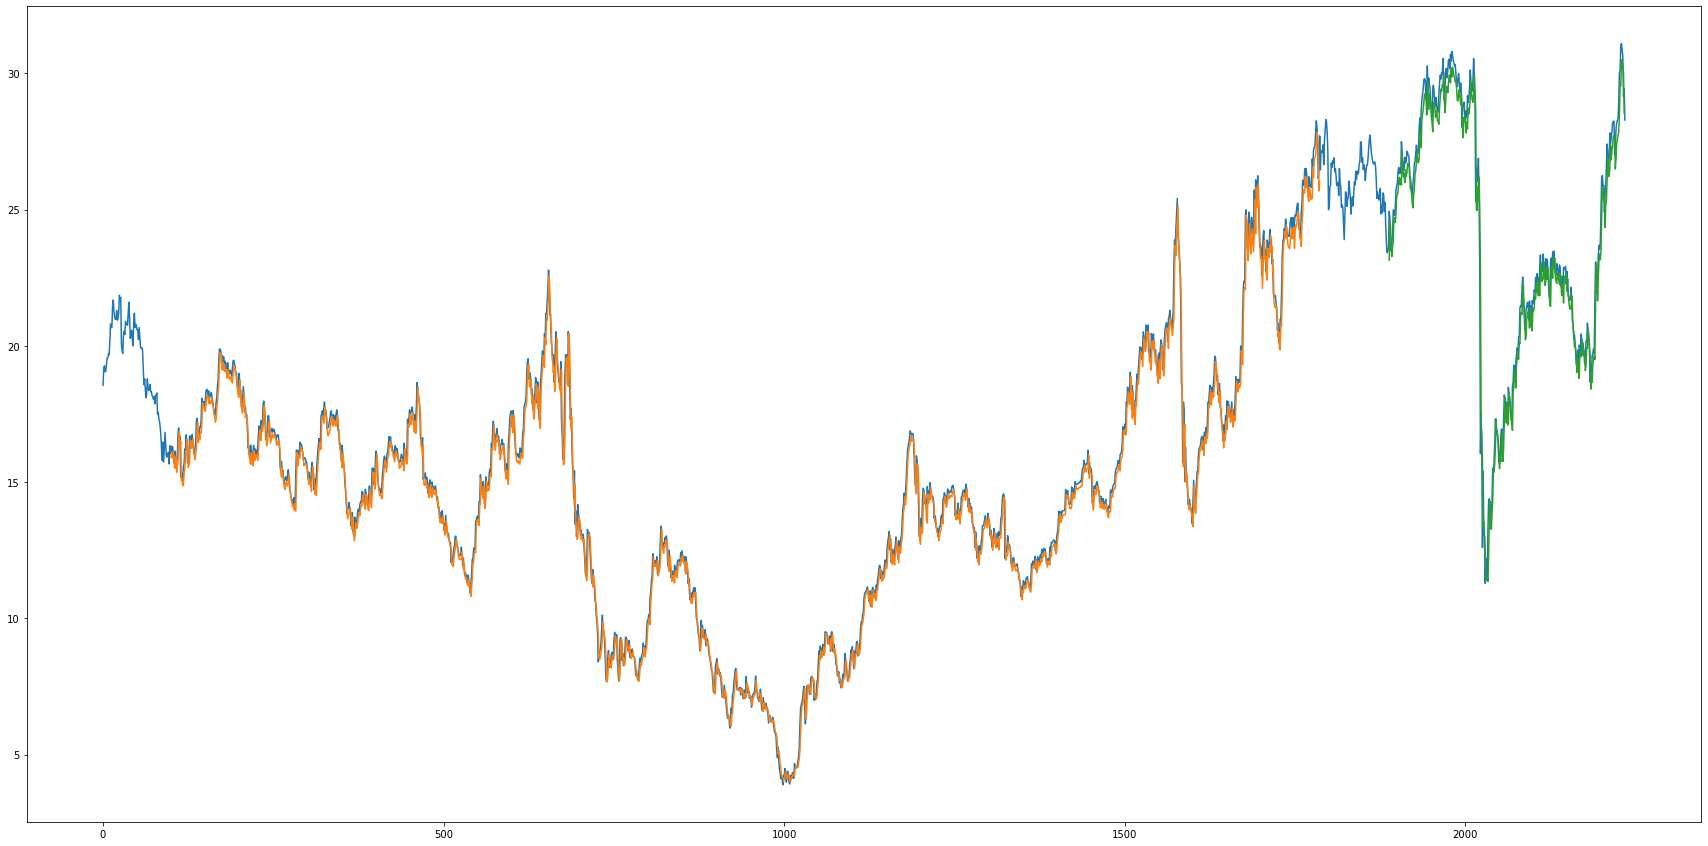

In [35]:
# plot baseline and predictions https://stackabuse.com/change-figure-size-in-matplotlib/
plt.figure(figsize=(30, 15))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

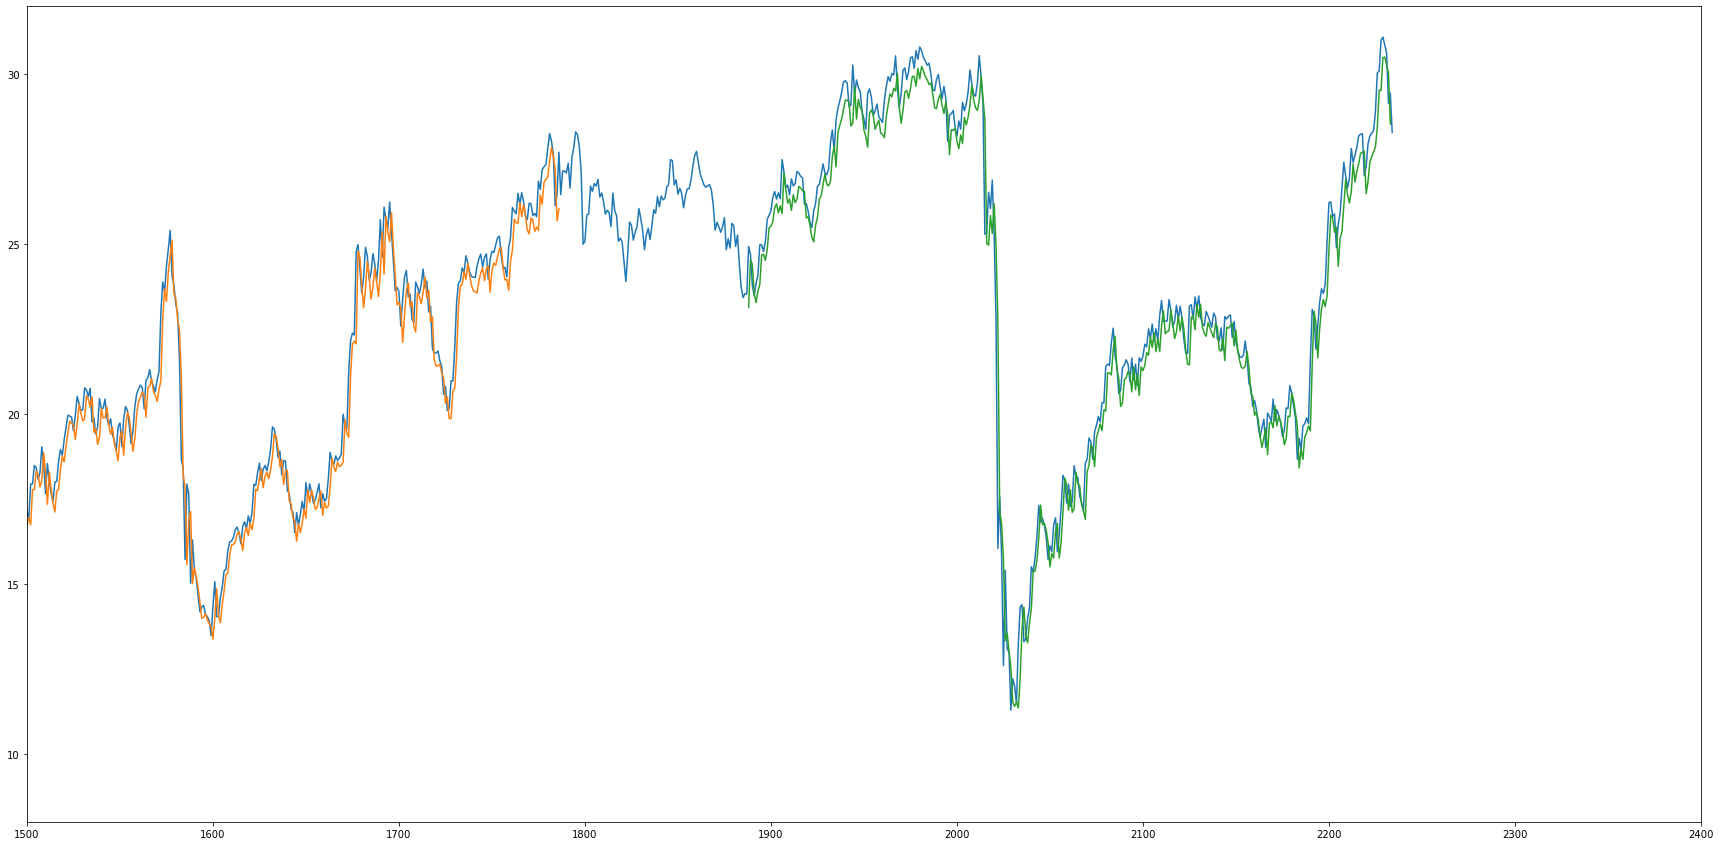

In [36]:
#Zoom in
plt.figure(figsize=(30, 15))
#adjust zoom in to the stock/security axis
plt.axis([1500,2400,8,32])
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [37]:
len(test_data)

447

In [38]:
x_input=test_data[(len(test_data)-100):].reshape(1,-1)
x_input.shape
#need to substract look_back days, hours

(1, 100)

In [39]:
#putting them on a list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [40]:
# demonstrate prediction for next X days, hours = time o/i
lst_output=[]
n_steps=100
i=0
while(i<30): # X days, hours, etc
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} time input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} time output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.8714852333068848], [0.8481135964393616], [0.8257107734680176], [0.8034926056861877], [0.782100260257721], [0.7625986337661743], [0.7447165250778198], [0.7284154891967773], [0.7136774063110352], [0.7004322409629822], [0.6885644197463989], [0.6779356598854065], [0.6683897376060486], [0.659758448600769], [0.6518673300743103], [0.6445441246032715], [0.6376246213912964], [0.630957841873169], [0.6244109869003296], [0.6178728342056274], [0.6112558245658875], [0.6044960618019104], [0.5975523591041565], [0.5904046297073364], [0.5830506086349487], [0.5755023956298828], [0.5677821636199951], [0.5599197149276733], [0.5519477128982544], [0.543899655342102]]


In [41]:
#predict for the next X days
#manual data
#day_new=np.arange(1,1+n_step)
#day_pred=np.arange(1+n_step,1+n_step+days)

time_new=np.arange(1,101)
time_pred=np.arange(101,131)

In [42]:
len(df1)

2235

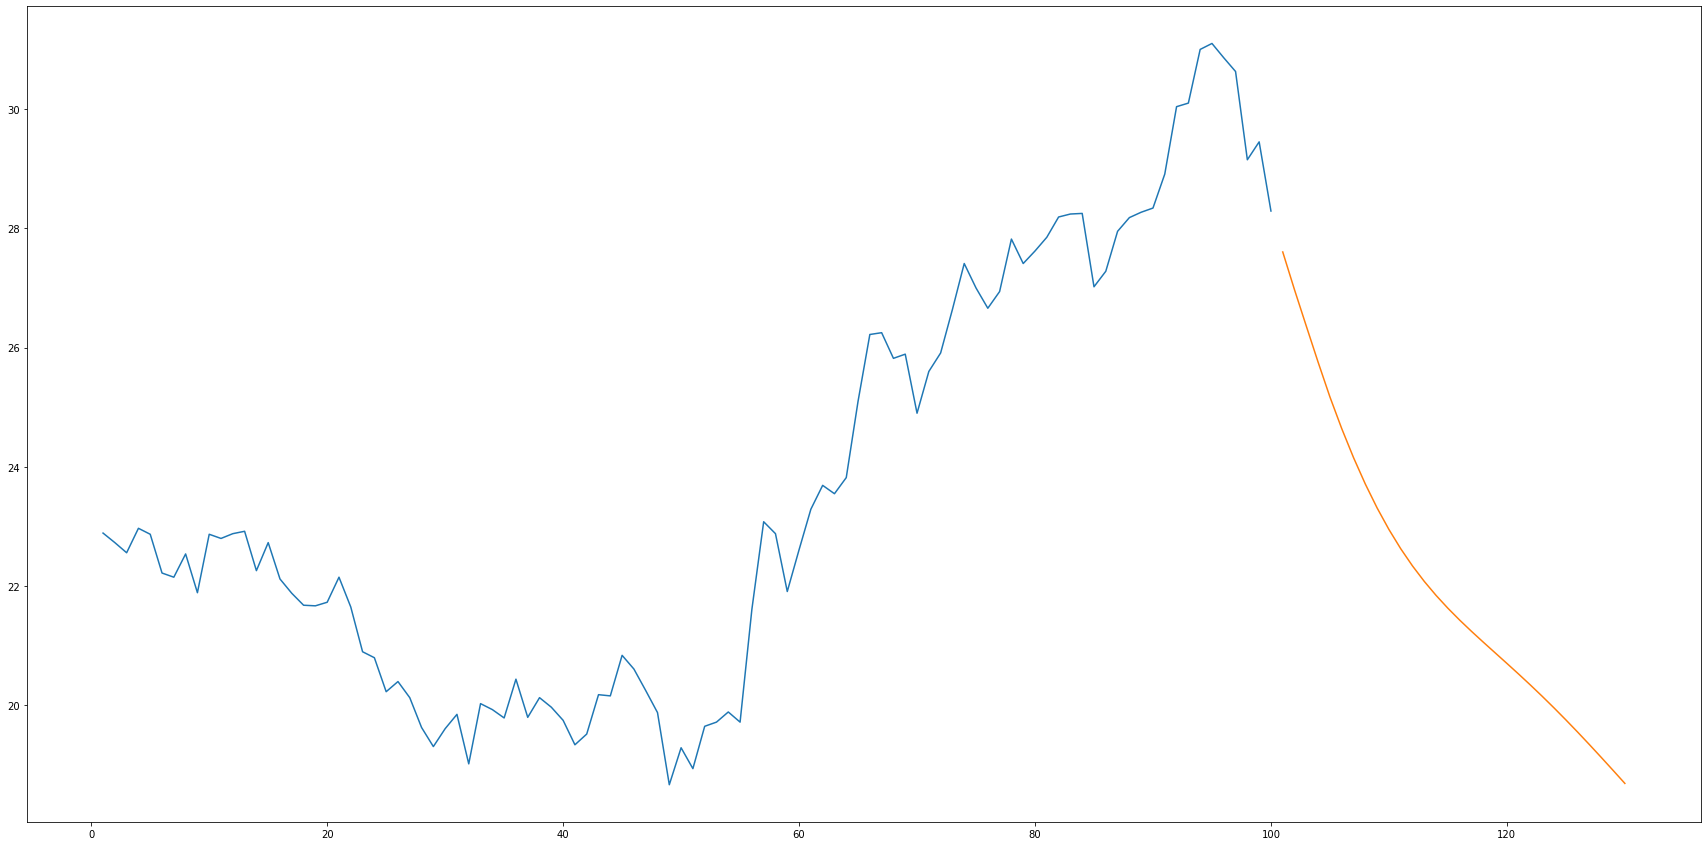

In [43]:
plt.figure(figsize=(30, 15))
plt.plot(time_new,scaler.inverse_transform(df1[(len(df1)-n_steps):]))
plt.plot(time_pred,scaler.inverse_transform(lst_output))
plt.show()

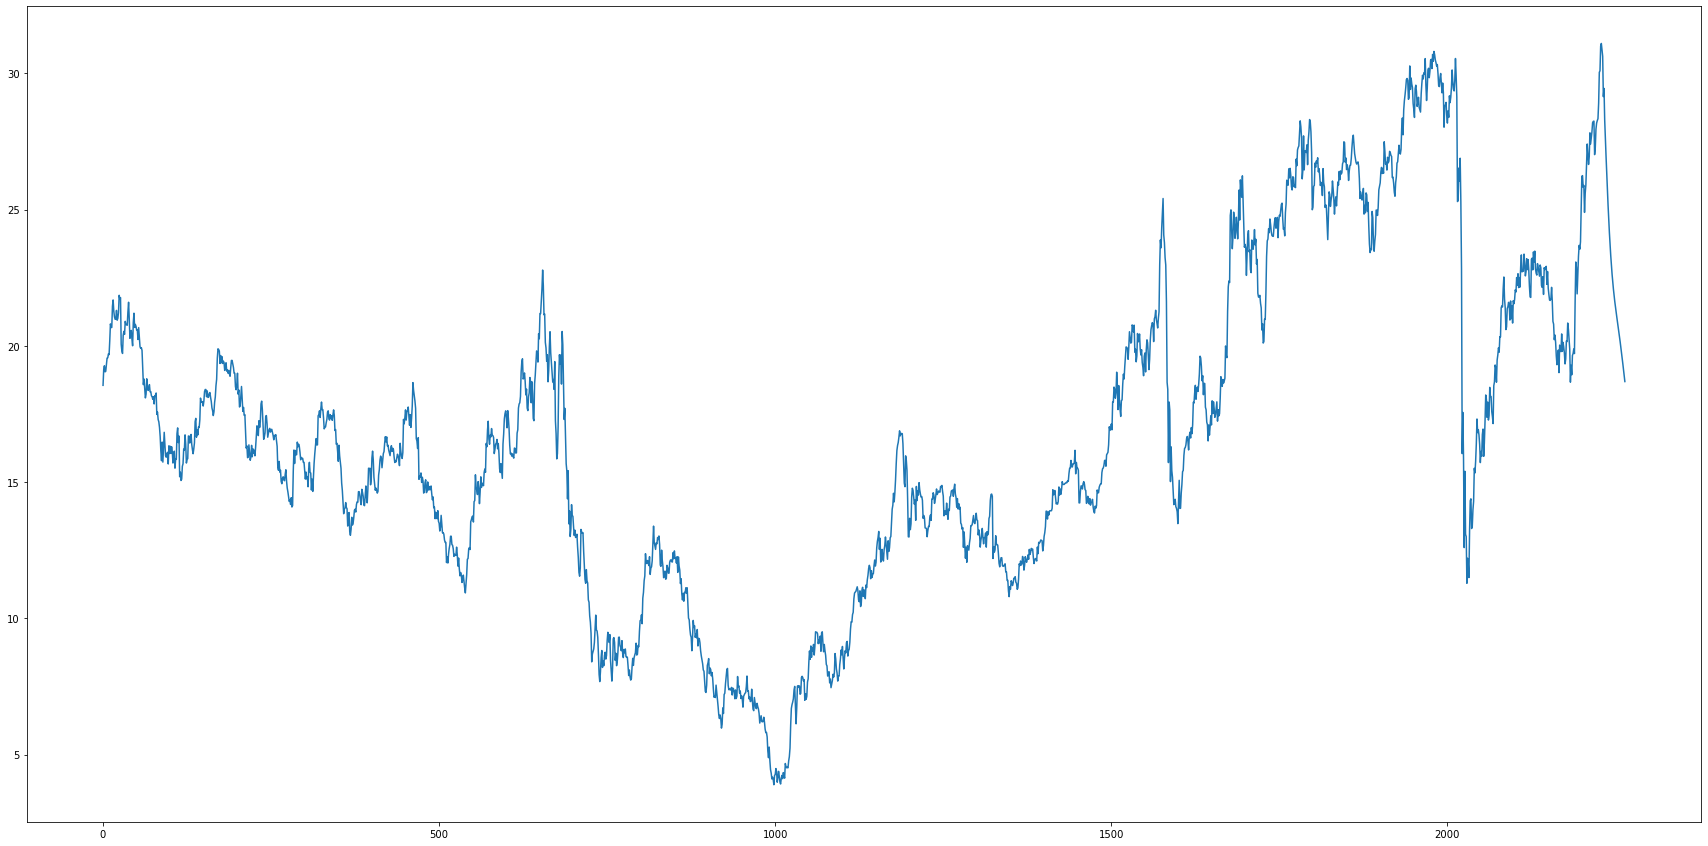

In [44]:
#extend prediction on the graph

df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()

plt.figure(figsize=(30, 15))
plt.plot(df3)
plt.show()

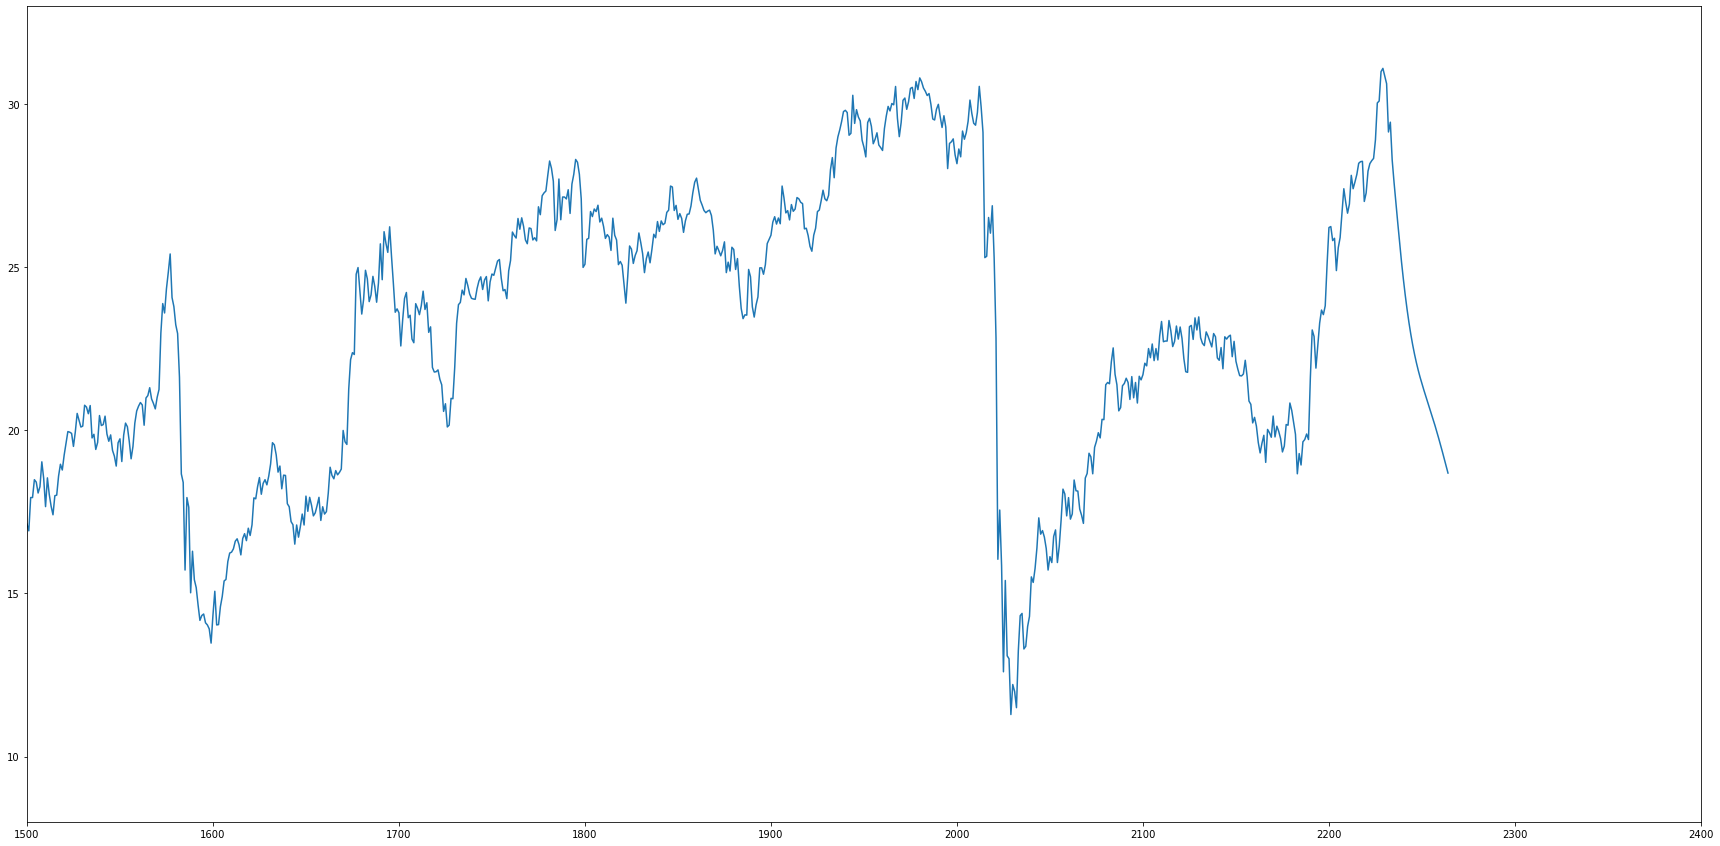

In [45]:
plt.figure(figsize=(30, 15))
#adjust zoom in to the stock/security axis
plt.axis([1500,2400,8,33])
plt.plot(df3)
plt.show()

### PART 2 - multy-layer only

In [46]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [47]:
df1=df0['Adj Close']
df1

0       18.554081
1       19.134697
2       19.271320
3       19.049313
4       19.066393
          ...    
2230    30.860001
2231    30.629999
2232    29.150000
2233    29.450001
2234    28.290001
Name: Adj Close, Length: 2235, dtype: float64

In [48]:
# minmax tool. Minmax 0 to -1
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [49]:
print(df1)

[[0.53881484]
 [0.56015815]
 [0.56518039]
 ...
 [0.92831841]
 [0.93934639]
 [0.89670505]]


In [50]:
##splitting dataset into train and test split

training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [51]:
training_size,test_size

(1788, 447)

In [52]:
#train_data

In [53]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [54]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [55]:
print(X_train.shape), print(y_train.shape)

(1687, 100)
(1687,)


(None, None)

In [56]:
print(X_test.shape), print(ytest.shape)

(346, 100)
(346,)


(None, None)

In [57]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [58]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [59]:
#creating LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)               

In [61]:
#fit model into test set and based on parameters (epochs, batch_size and verbose). Those parameters can be optimized

In [62]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

# epochs = interaction
# in most cases, an optimal batch-size is 64
# Verbose=0 (silent) Verbose=1 (progress bar)

Epoch 1/200
27/27 [==============================] - 33s 746ms/step - loss: 0.0784 - val_loss: 0.0980
Epoch 2/200
27/27 [==============================] - 16s 611ms/step - loss: 0.0126 - val_loss: 0.0229
Epoch 3/200
27/27 [==============================] - 16s 607ms/step - loss: 0.0057 - val_loss: 0.0211
Epoch 4/200
27/27 [==============================] - 16s 607ms/step - loss: 0.0051 - val_loss: 0.0205
Epoch 5/200
27/27 [==============================] - 16s 610ms/step - loss: 0.0047 - val_loss: 0.0156
Epoch 6/200
27/27 [==============================] - 16s 606ms/step - loss: 0.0053 - val_loss: 0.0152
Epoch 7/200
27/27 [==============================] - 16s 603ms/step - loss: 0.0038 - val_loss: 0.0150
Epoch 8/200
27/27 [==============================] - 16s 601ms/step - loss: 0.0034 - val_loss: 0.0121
Epoch 9/200
27/27 [==============================] - 16s 606ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 10/200
27/27 [==============================] - 16s 607ms/step - loss: 0.003

In [63]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [64]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [65]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

14.949955129950938

In [66]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

23.51536660056236

In [67]:
### Plotting 
# shift train predictions for plotting
look_back=100 #must change in accordance to step_back
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

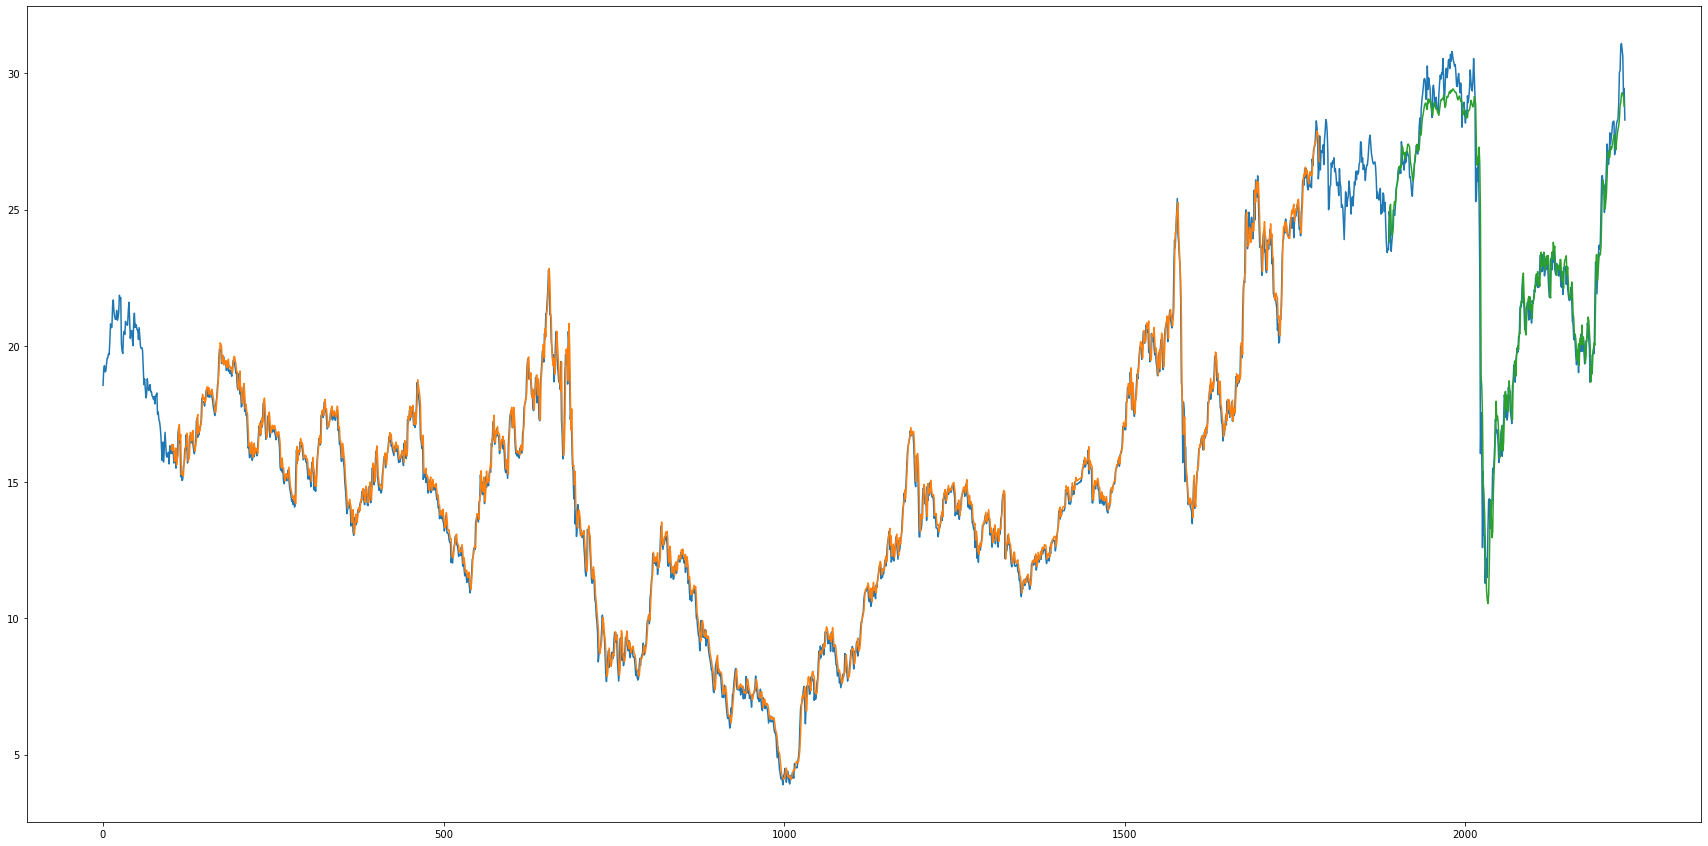

In [68]:
# plot baseline and predictions https://stackabuse.com/change-figure-size-in-matplotlib/
plt.figure(figsize=(30, 15))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

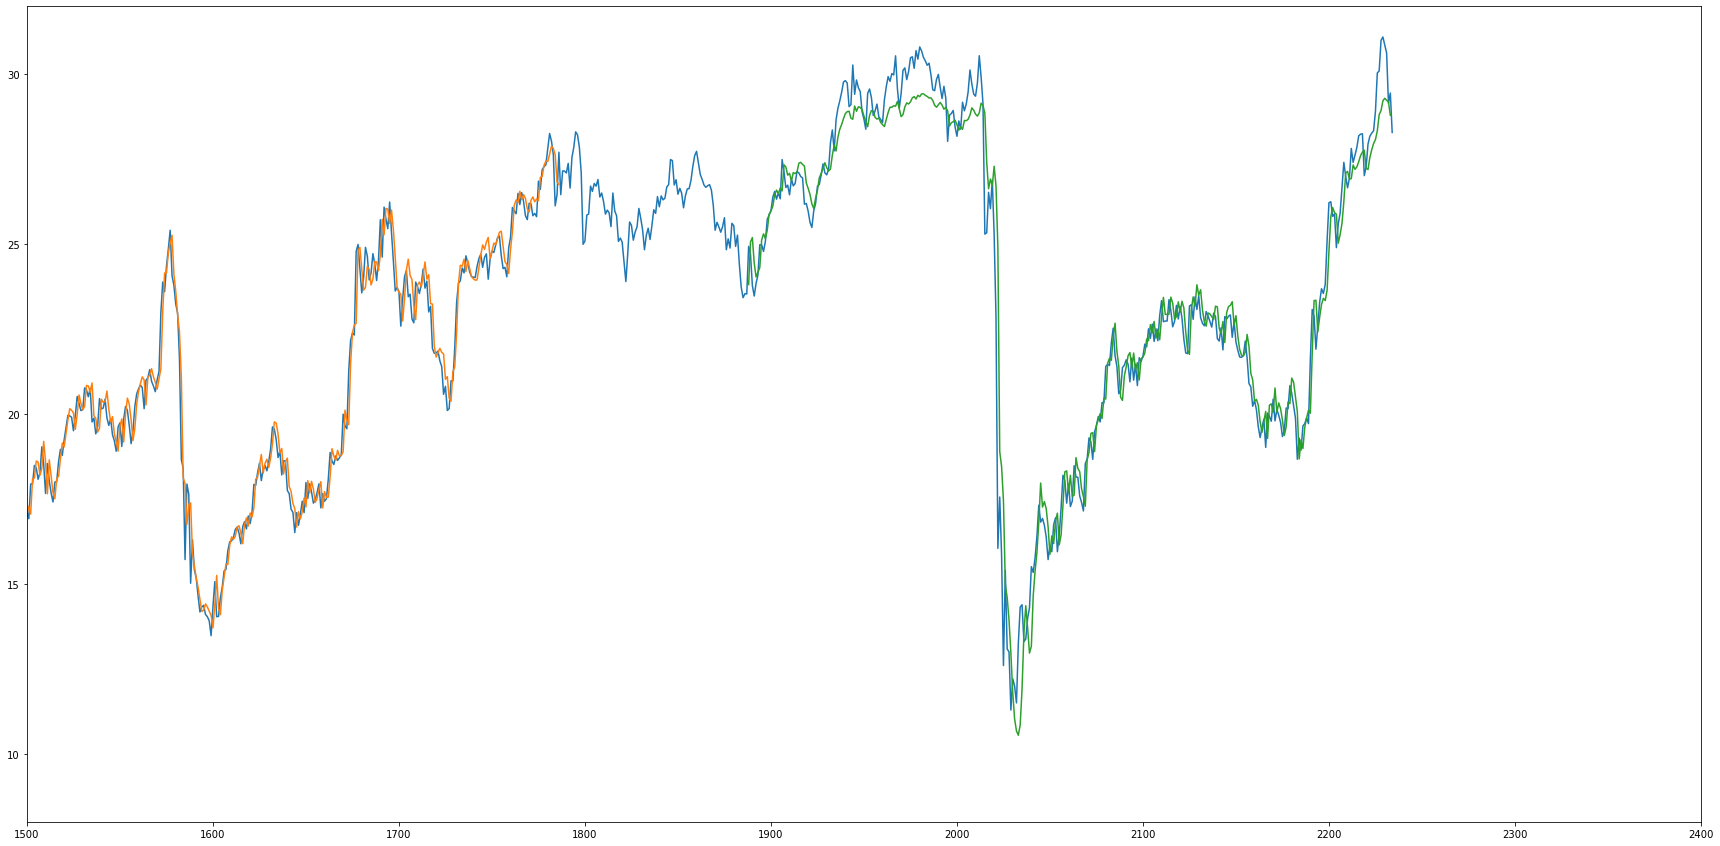

In [69]:
#Zoom in
plt.figure(figsize=(30, 15))
#adjust zoom in to the stock/security axis
plt.axis([1500,2400,8,32])
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [70]:
len(test_data)

447

In [71]:
x_input=test_data[(len(test_data)-100):].reshape(1,-1)
x_input.shape
#need to substract look_back days, hours

(1, 100)

In [72]:
#putting them on a list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [73]:
# demonstrate prediction for next X days, hours = time o/i
lst_output=[]
n_steps=100
i=0
while(i<30): # X days, hours, etc
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} time input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} time output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.901299774646759], [0.8989818096160889], [0.8986985087394714], [0.89888596534729], [0.9004029035568237], [0.9019836187362671], [0.9031935334205627], [0.9037670493125916], [0.9033969640731812], [0.9020931124687195], [0.900080144405365], [0.8976855278015137], [0.8952546715736389], [0.8930655121803284], [0.8912946581840515], [0.8900158405303955], [0.8892148733139038], [0.8888180255889893], [0.8887178897857666], [0.8887955546379089], [0.8889455199241638], [0.8890857100486755], [0.8891677260398865], [0.8891726732254028], [0.8891081213951111], [0.8889985084533691], [0.8888744115829468], [0.8887630105018616], [0.8886892199516296], [0.8886624574661255]]


In [74]:
#predict for the next X days
#manual data
#day_new=np.arange(1,1+n_step)
#day_pred=np.arange(1+n_step,1+n_step+days)

time_new=np.arange(1,101)
time_pred=np.arange(101,131)

In [75]:
len(df1)

2235

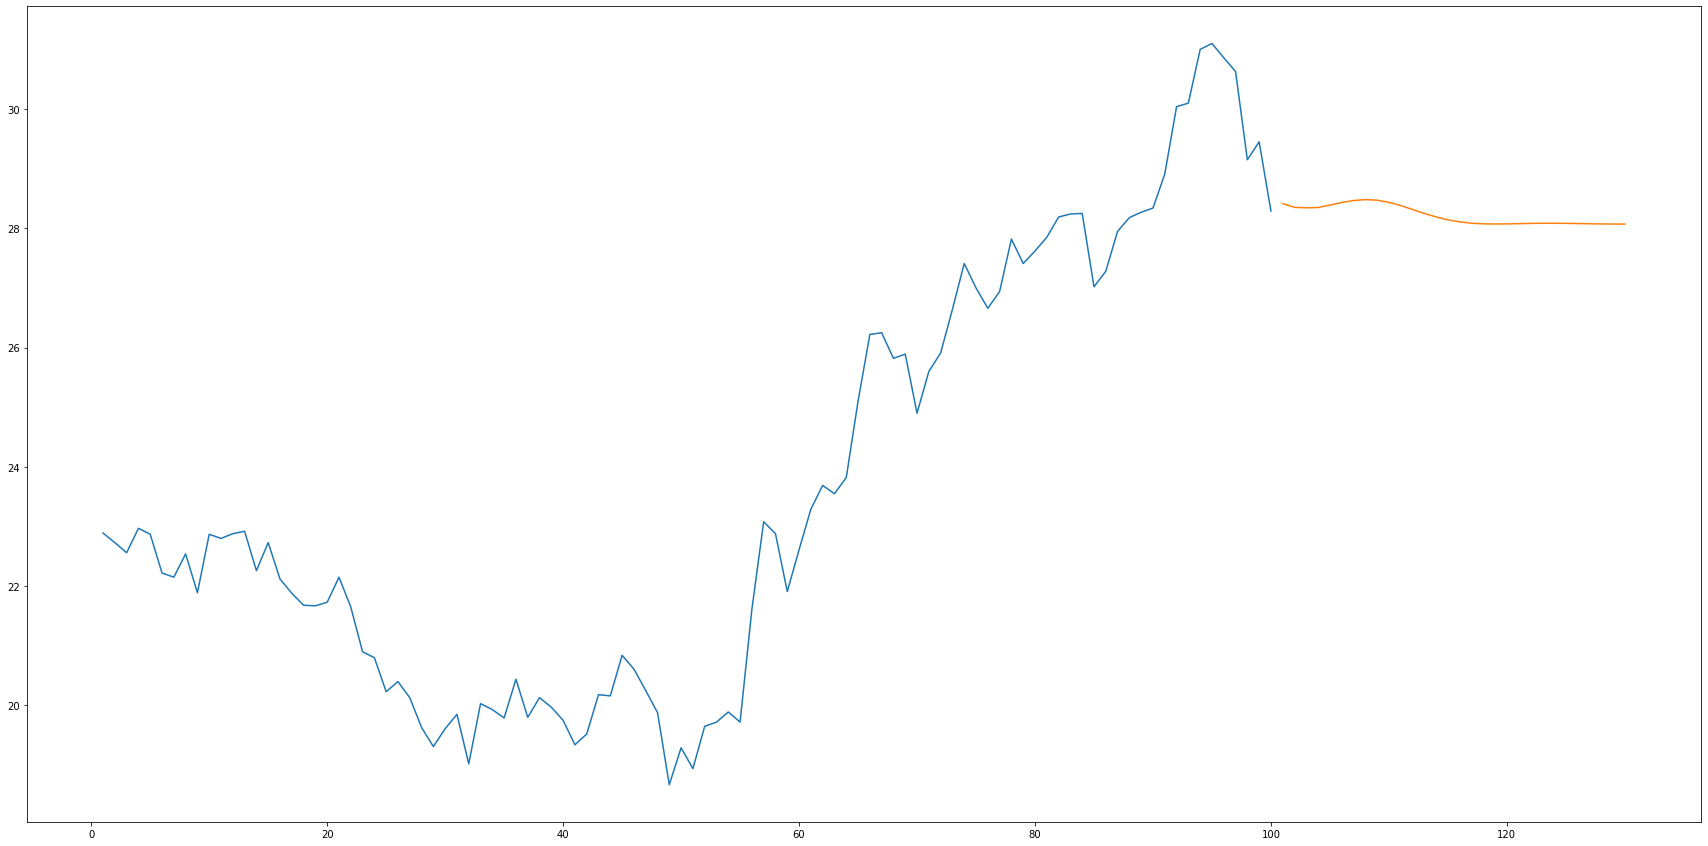

In [76]:
plt.figure(figsize=(30, 15))
plt.plot(time_new,scaler.inverse_transform(df1[(len(df1)-n_steps):]))
plt.plot(time_pred,scaler.inverse_transform(lst_output))
plt.show()

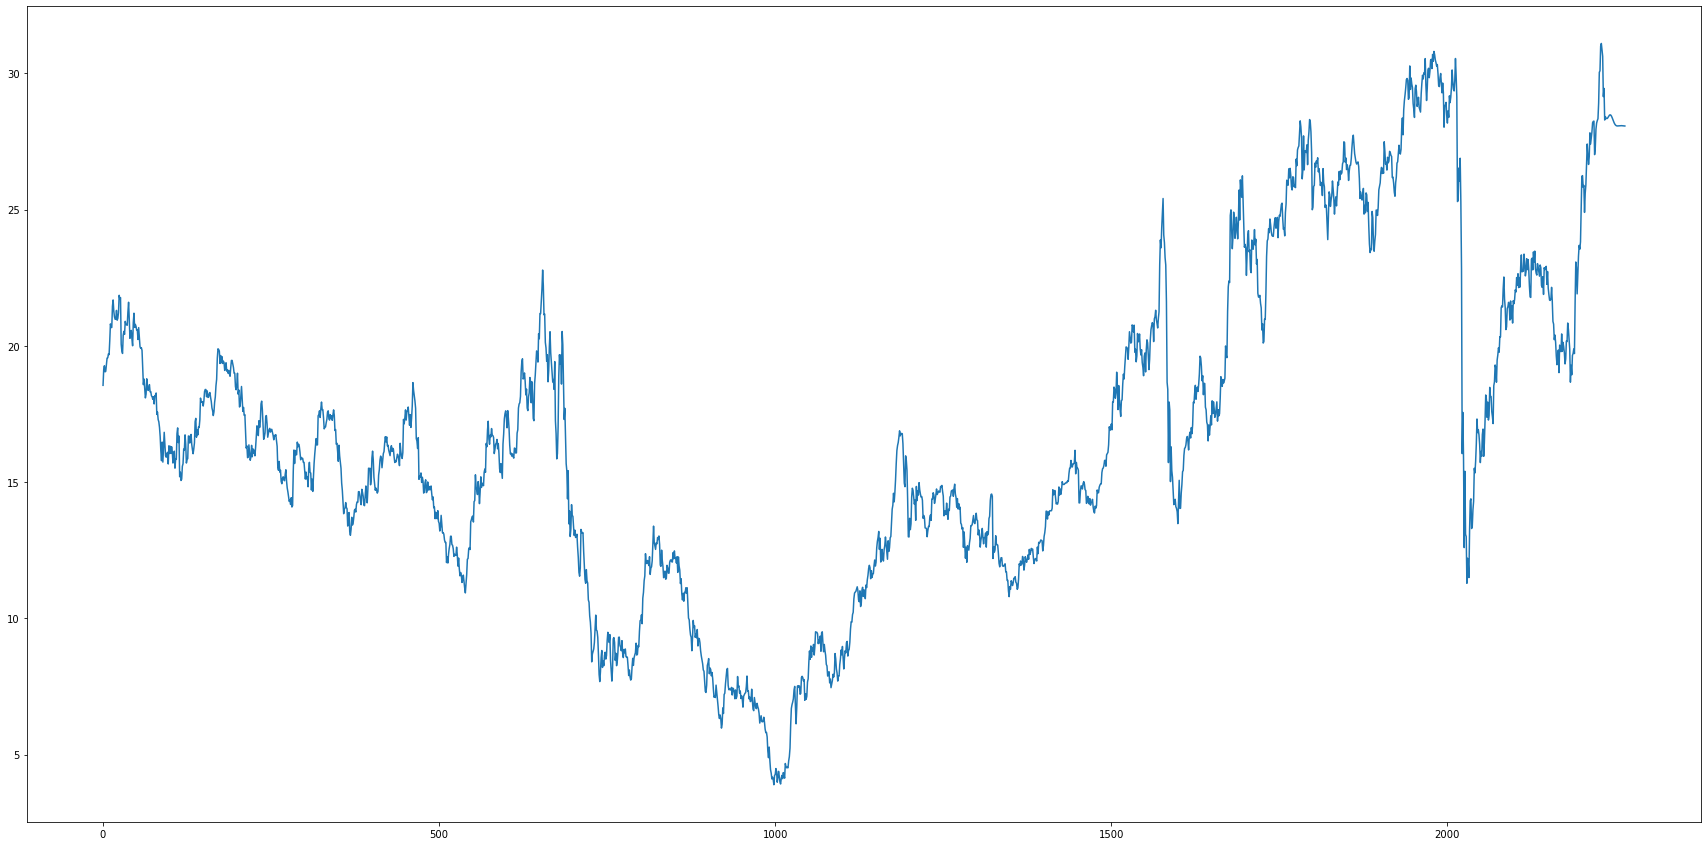

In [77]:
#extend prediction on the graph

df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()

plt.figure(figsize=(30, 15))
plt.plot(df3)
plt.show()

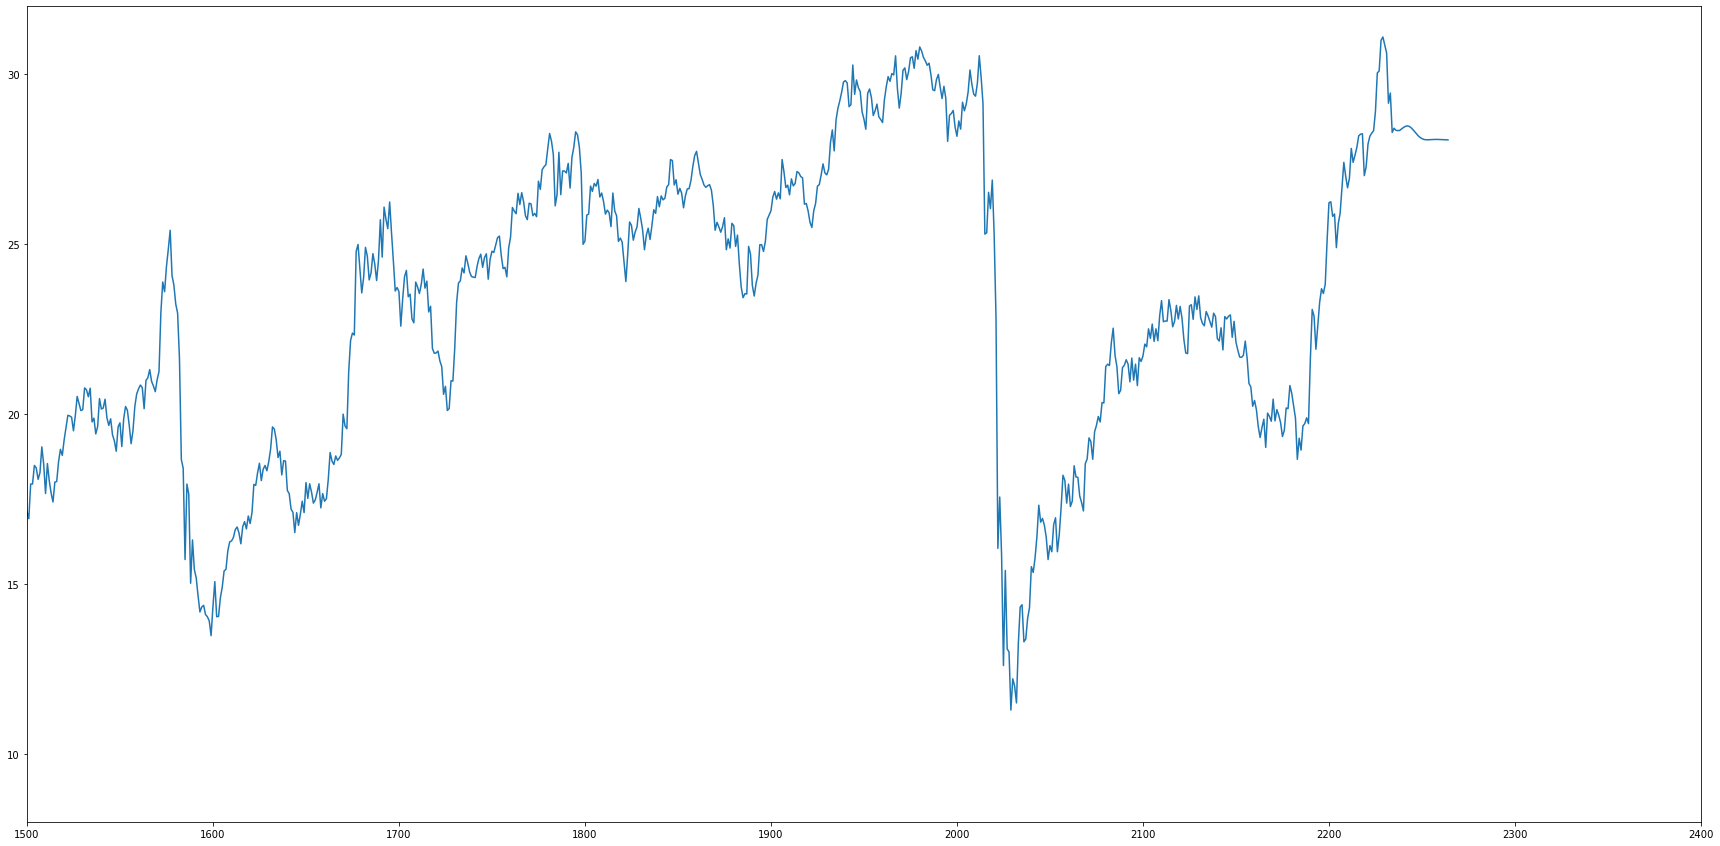

In [78]:
plt.figure(figsize=(30, 15))
#adjust zoom in to the stock/security axis
plt.axis([1500,2400,8,32])
plt.plot(df3)
plt.show()

### PART 3 - Bidirectional

In [79]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [80]:
df1=df0['Adj Close']
df1

0       18.554081
1       19.134697
2       19.271320
3       19.049313
4       19.066393
          ...    
2230    30.860001
2231    30.629999
2232    29.150000
2233    29.450001
2234    28.290001
Name: Adj Close, Length: 2235, dtype: float64

In [81]:
# minmax tool. Minmax 0 to -1
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [82]:
print(df1)

[[0.53881484]
 [0.56015815]
 [0.56518039]
 ...
 [0.92831841]
 [0.93934639]
 [0.89670505]]


In [83]:
##splitting dataset into train and test split

training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [84]:
training_size,test_size

(1788, 447)

In [85]:
#train_data

In [86]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [87]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [88]:
print(X_train.shape), print(y_train.shape)

(1687, 100)
(1687,)


(None, None)

In [89]:
print(X_test.shape), print(ytest.shape)

(346, 100)
(346,)


(None, None)

In [90]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [91]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [92]:
#creating LSTM

model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(100, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [94]:
#fit model into test set and based on parameters (epochs, batch_size and verbose). Those parameters can be optimized

In [95]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

# epochs = interaction
# in most cases, an optimal batch-size is 64
# Verbose=0 (silent) Verbose=1 (progress bar)

Epoch 1/200
27/27 [==============================] - 7s 159ms/step - loss: 0.1127 - val_loss: 0.0637
Epoch 2/200
27/27 [==============================] - 4s 142ms/step - loss: 0.0117 - val_loss: 0.0276
Epoch 3/200
27/27 [==============================] - 4s 141ms/step - loss: 0.0049 - val_loss: 0.0191
Epoch 4/200
27/27 [==============================] - 4s 135ms/step - loss: 0.0030 - val_loss: 0.0213
Epoch 5/200
27/27 [==============================] - 4s 141ms/step - loss: 0.0019 - val_loss: 0.0116
Epoch 6/200
27/27 [==============================] - 4s 141ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 7/200
27/27 [==============================] - 4s 132ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 8/200
27/27 [==============================] - 4s 131ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 9/200
27/27 [==============================] - 3s 128ms/step - loss: 9.6044e-04 - val_loss: 0.0058
Epoch 10/200
27/27 [==============================] - 3s 127ms/step - loss: 9.3206e-04 

In [96]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [97]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [98]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

14.775293224884441

In [99]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

23.75204358248698

In [100]:
### Plotting 
# shift train predictions for plotting
look_back=100 #must change in accordance to step_back
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

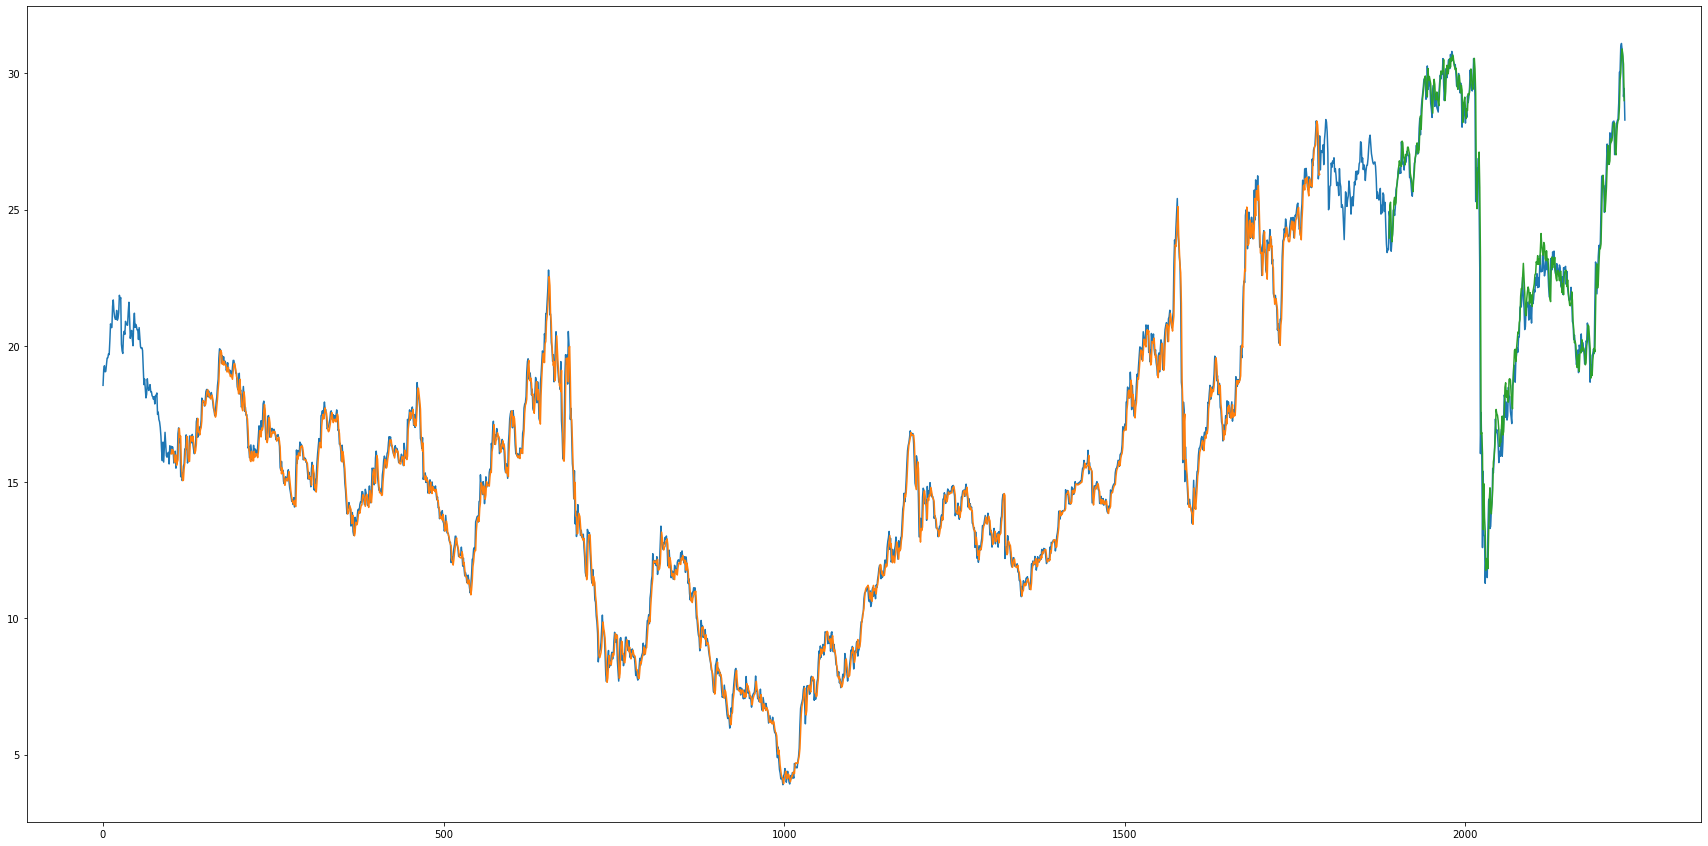

In [101]:
# plot baseline and predictions https://stackabuse.com/change-figure-size-in-matplotlib/
plt.figure(figsize=(30, 15))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

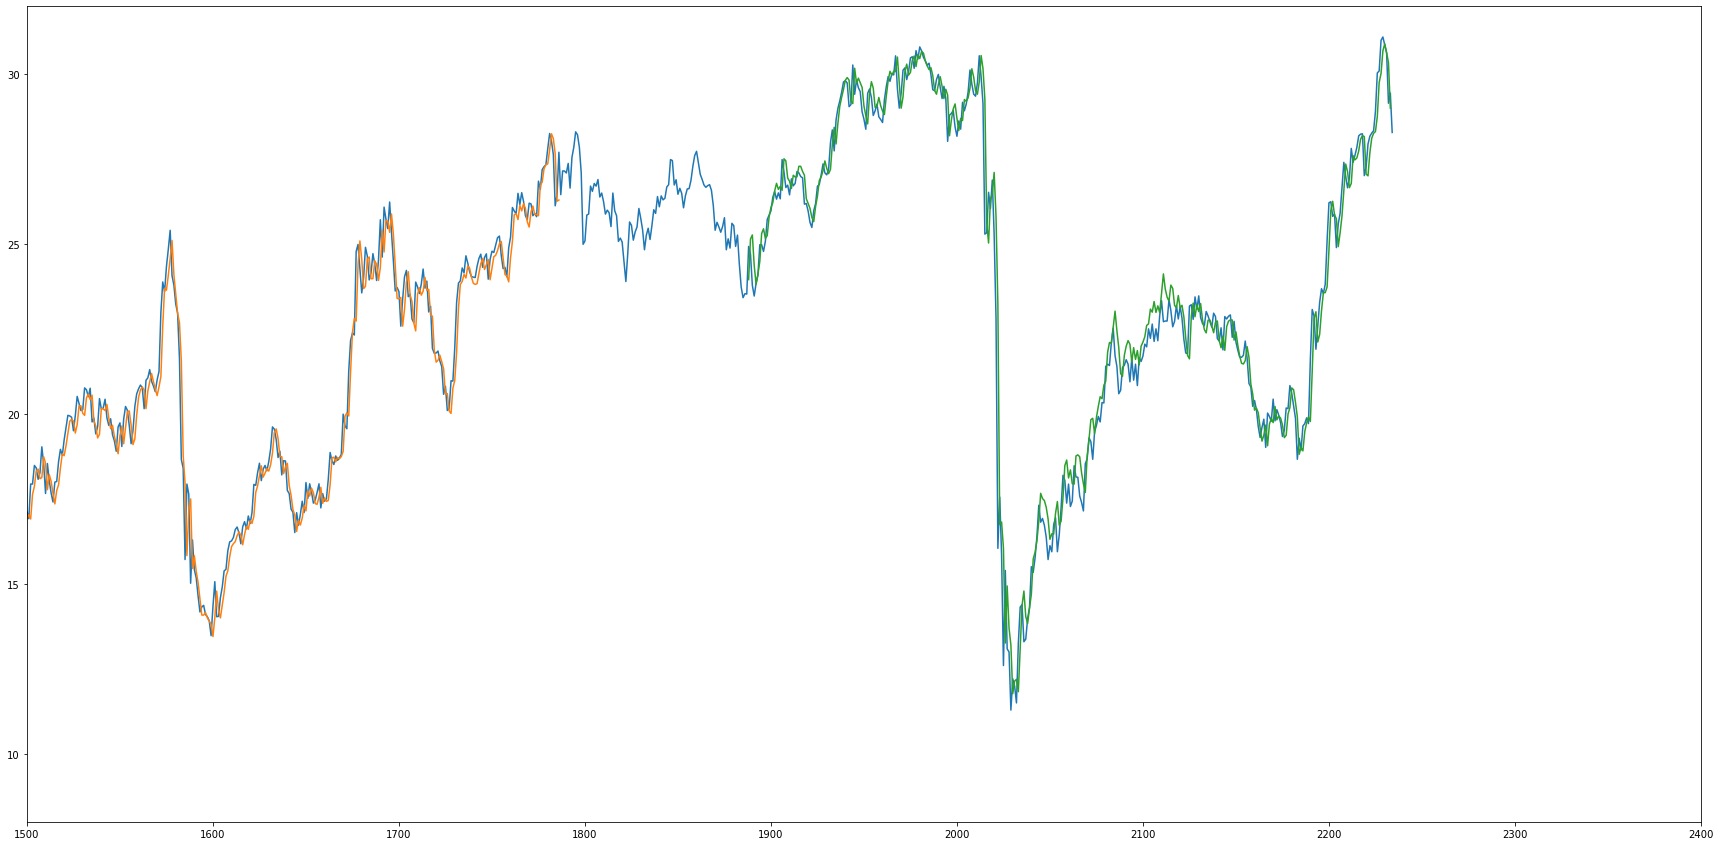

In [102]:
#Zoom in
plt.figure(figsize=(30, 15))
#adjust zoom in to the stock/security axis
plt.axis([1500,2400,8,32])
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [103]:
len(test_data)

447

In [104]:
x_input=test_data[(len(test_data)-100):].reshape(1,-1)
x_input.shape
#need to substract look_back days, hours

(1, 100)

In [105]:
#putting them on a list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [106]:
# demonstrate prediction for next X days, hours = time o/i
lst_output=[]
n_steps=100
i=0
while(i<30): # X days, hours, etc
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} time input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} time output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.8951669335365295], [0.8896701335906982], [0.8885477185249329], [0.8891050219535828], [0.8894178867340088], [0.8890395164489746], [0.8883927464485168], [0.8874131441116333], [0.8859218955039978], [0.884790301322937], [0.8831049203872681], [0.8811326026916504], [0.8786232471466064], [0.8754342198371887], [0.8721807599067688], [0.8681179881095886], [0.86395263671875], [0.8597762584686279], [0.8557844161987305], [0.8519099354743958], [0.8479067087173462], [0.8430033922195435], [0.8375292420387268], [0.8317758440971375], [0.8256720900535583], [0.8195648193359375], [0.8132607340812683], [0.8069255352020264], [0.8008164167404175], [0.7951272130012512]]


In [107]:
#predict for the next X days
#manual data
#day_new=np.arange(1,1+n_step)
#day_pred=np.arange(1+n_step,1+n_step+days)

time_new=np.arange(1,101)
time_pred=np.arange(101,131)

In [108]:
len(df1)

2235

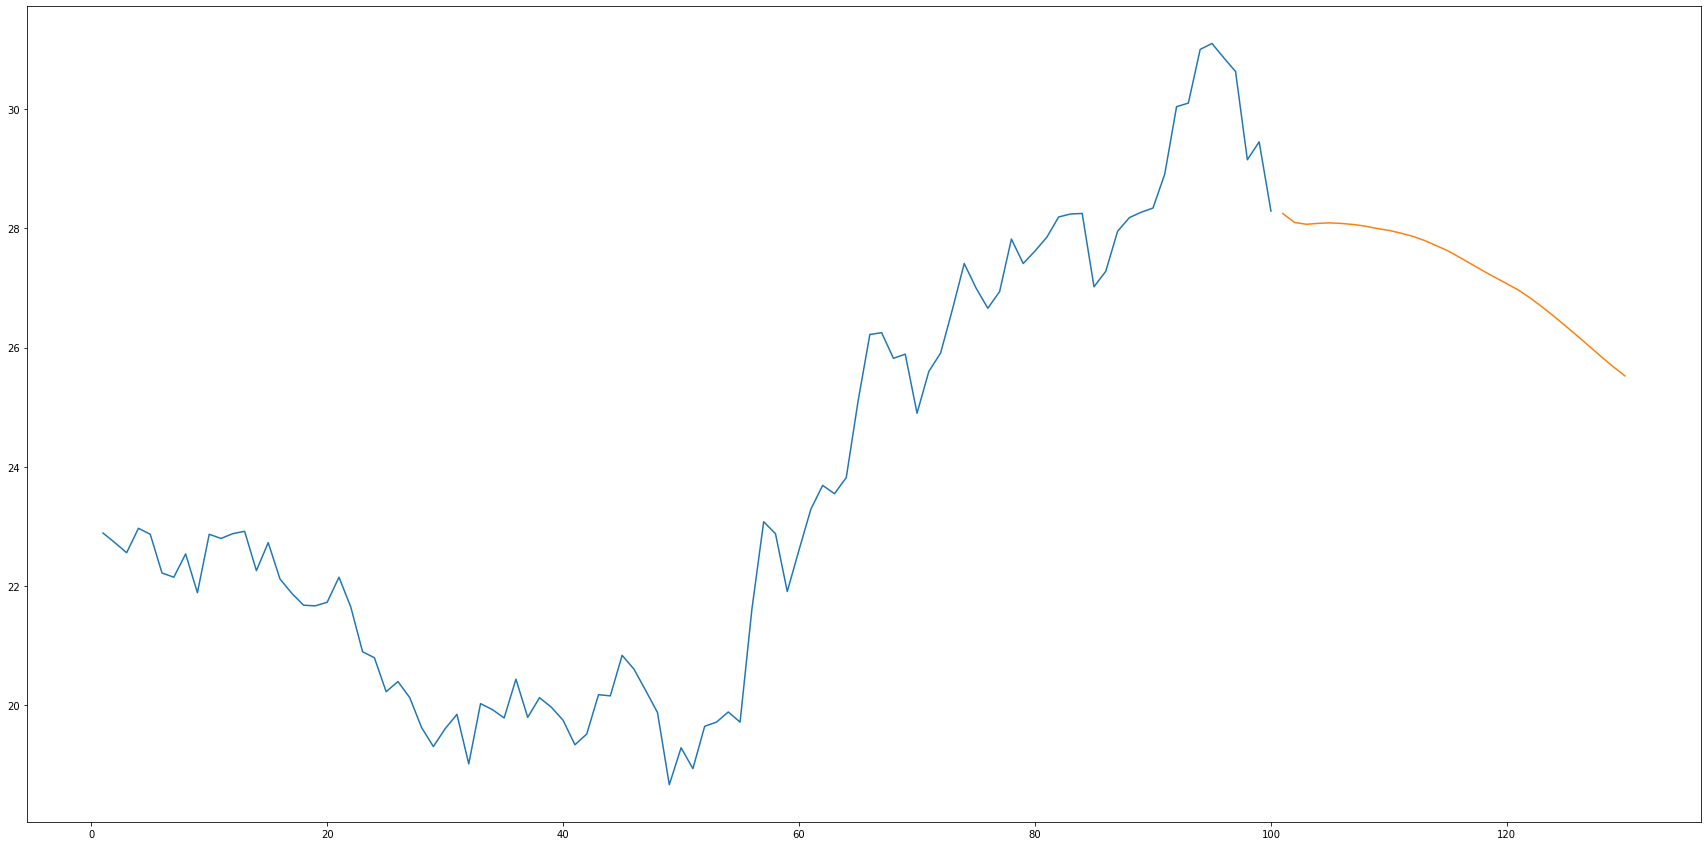

In [109]:
plt.figure(figsize=(30, 15))
plt.plot(time_new,scaler.inverse_transform(df1[(len(df1)-n_steps):]))
plt.plot(time_pred,scaler.inverse_transform(lst_output))
plt.show()

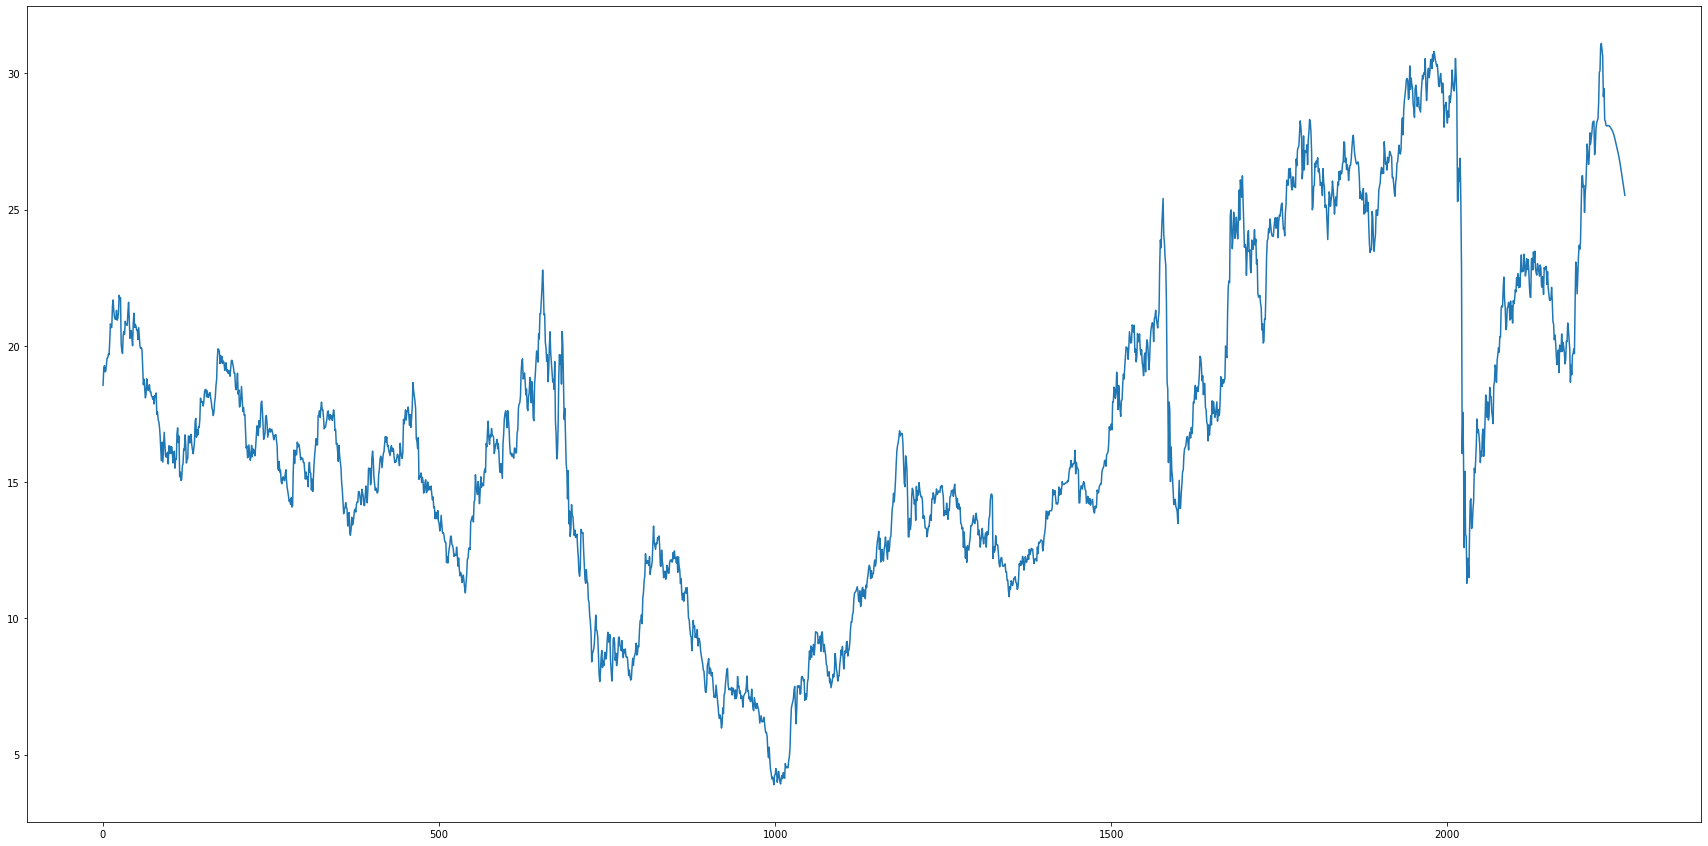

In [110]:
#extend prediction on the graph

df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()

plt.figure(figsize=(30, 15))
plt.plot(df3)
plt.show()

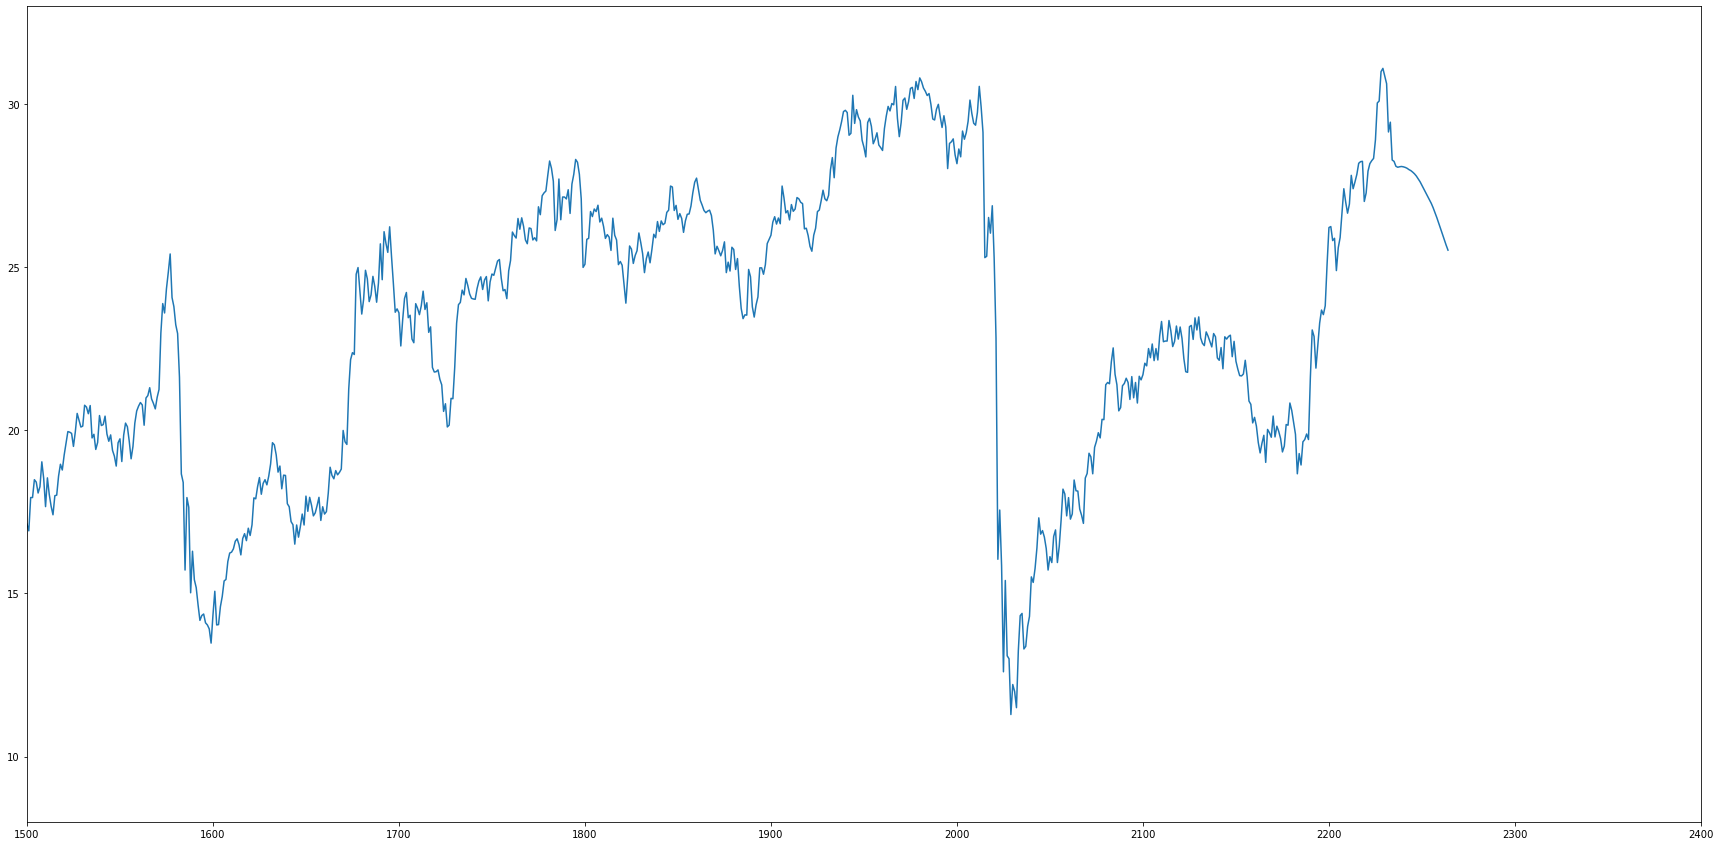

In [111]:
plt.figure(figsize=(30, 15))
#adjust zoom in to the stock/security axis
plt.axis([1500,2400,8,33])
plt.plot(df3)
plt.show()

### PART 4 - Multilayer + Relu

In [112]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [113]:
df1=df0['Adj Close']
df1

0       18.554081
1       19.134697
2       19.271320
3       19.049313
4       19.066393
          ...    
2230    30.860001
2231    30.629999
2232    29.150000
2233    29.450001
2234    28.290001
Name: Adj Close, Length: 2235, dtype: float64

In [114]:
# minmax tool. Minmax 0 to -1
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [115]:
print(df1)

[[0.53881484]
 [0.56015815]
 [0.56518039]
 ...
 [0.92831841]
 [0.93934639]
 [0.89670505]]


In [116]:
##splitting dataset into train and test split

training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [117]:
training_size,test_size

(1788, 447)

In [118]:
#train_data

In [119]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [120]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [121]:
print(X_train.shape), print(y_train.shape)

(1687, 100)
(1687,)


(None, None)

In [122]:
print(X_test.shape), print(ytest.shape)

(346, 100)
(346,)


(None, None)

In [123]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [124]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [125]:
#creating LSTM

model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100, 200)          161600    
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 100)          120400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           30200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [126]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100, 200)          161600    
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 100)          120400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           30200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [127]:
#fit model into test set and based on parameters (epochs, batch_size and verbose). Those parameters can be optimized

In [128]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

# epochs = interaction
# in most cases, an optimal batch-size is 64
# Verbose=0 (silent) Verbose=1 (progress bar)

Epoch 1/200
27/27 [==============================] - 21s 578ms/step - loss: 0.0832 - val_loss: 0.0259
Epoch 2/200
27/27 [==============================] - 15s 540ms/step - loss: 0.0058 - val_loss: 0.0156
Epoch 3/200
27/27 [==============================] - 14s 534ms/step - loss: 0.0037 - val_loss: 0.0113
Epoch 4/200
27/27 [==============================] - 14s 537ms/step - loss: 0.0026 - val_loss: 0.0121
Epoch 5/200
27/27 [==============================] - 14s 535ms/step - loss: 0.0033 - val_loss: 0.0087
Epoch 6/200
27/27 [==============================] - 14s 531ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 7/200
27/27 [==============================] - 14s 538ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 8/200
27/27 [==============================] - 14s 533ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 9/200
27/27 [==============================] - 14s 527ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 10/200
27/27 [==============================] - 14s 528ms/step - loss: 0.001

In [129]:
score = model.evaluate(X_test, ytest, batch_size=16)
score

22/22 [==============================] - 2s 74ms/step - loss: 8.5804e-04


0.0008580363355576992

In [130]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [131]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [132]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

14.908304241748874

In [133]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

23.860540877594893

In [134]:
### Plotting 
# shift train predictions for plotting
look_back=100 #must change in accordance to step_back
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

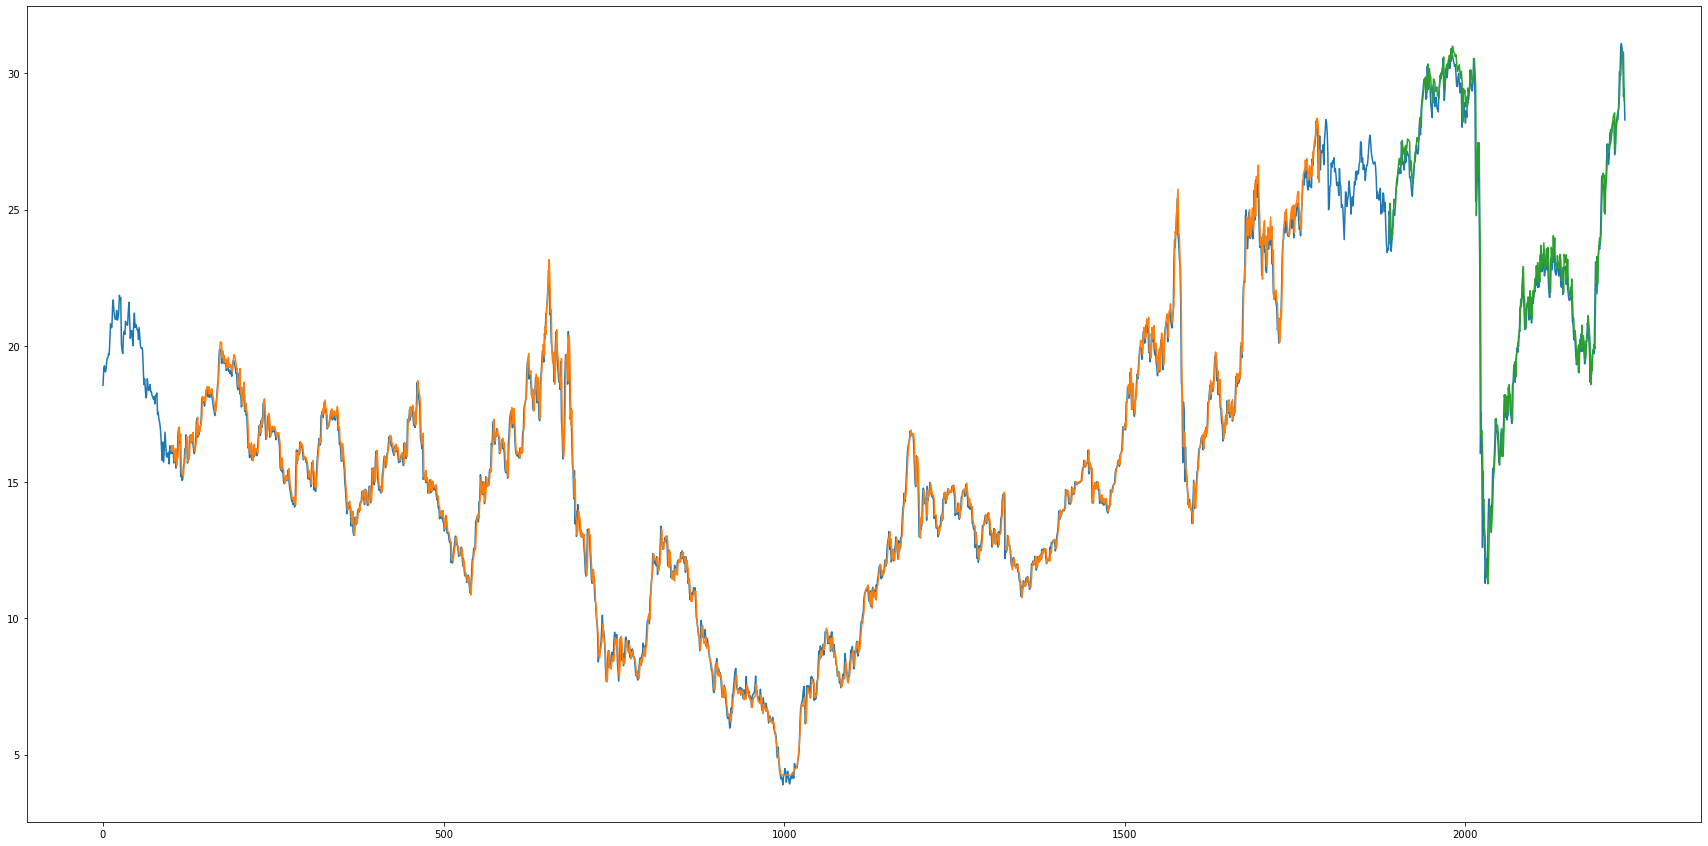

In [135]:
# plot baseline and predictions https://stackabuse.com/change-figure-size-in-matplotlib/
plt.figure(figsize=(30, 15))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

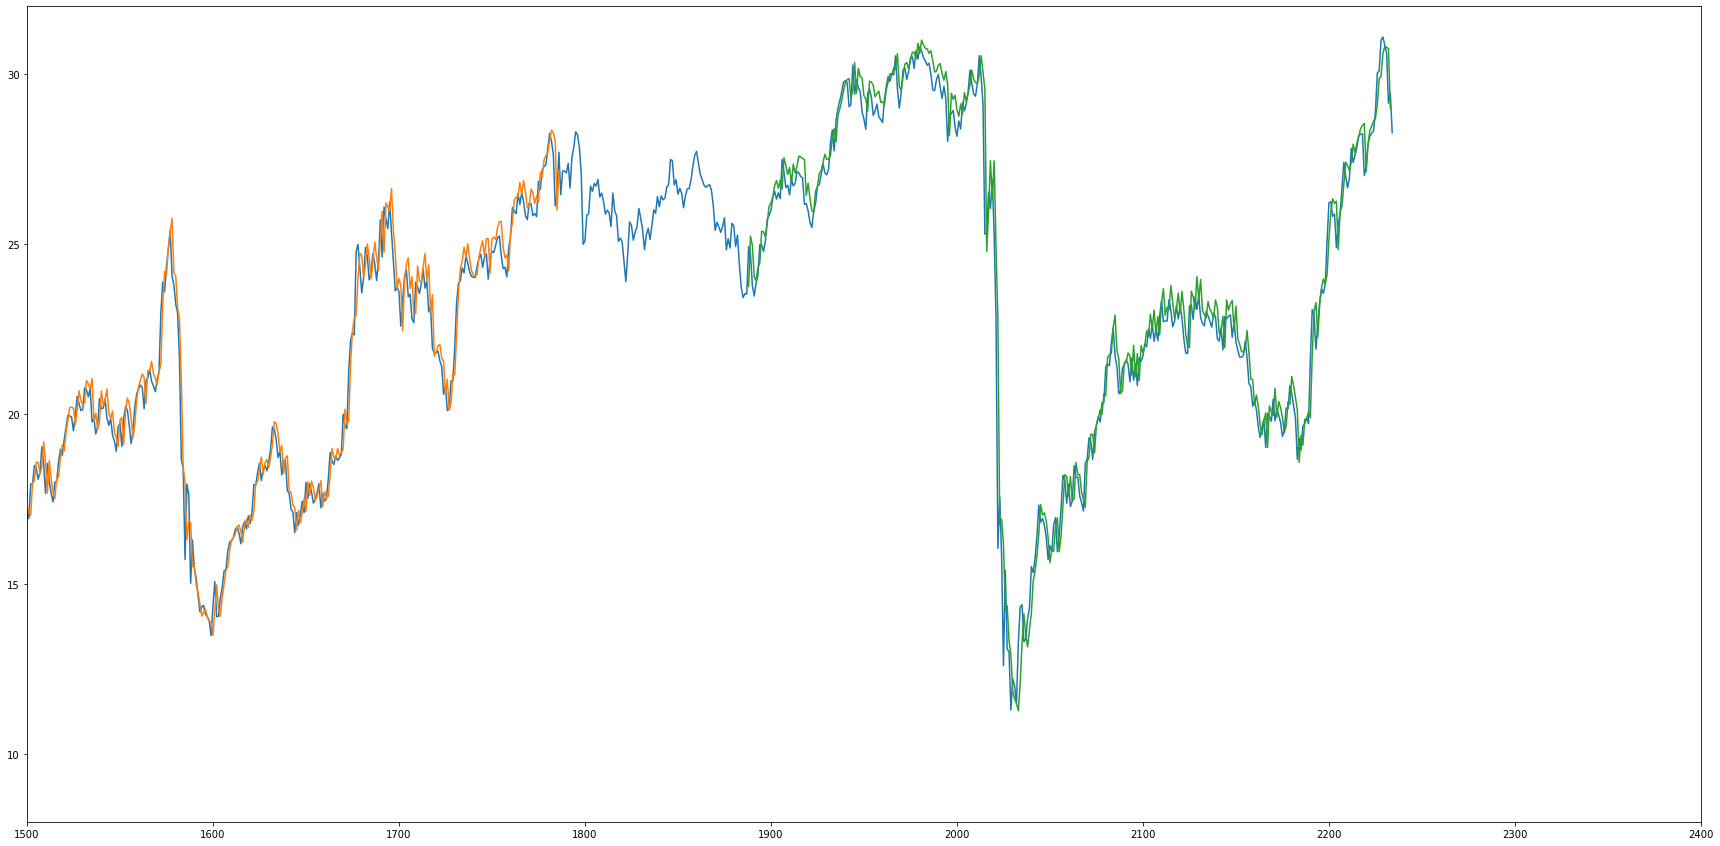

In [136]:
#Zoom in
plt.figure(figsize=(30, 15))
#adjust zoom in to the stock/security axis
plt.axis([1500,2400,8,32])
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [137]:
len(test_data)

447

In [138]:
x_input=test_data[(len(test_data)-100):].reshape(1,-1)
x_input.shape
#need to substract look_back days, hours

(1, 100)

In [139]:
#putting them on a list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [140]:
# demonstrate prediction for next X days, hours = time o/i
lst_output=[]
n_steps=100
i=0
while(i<30): # X days, hours, etc
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} time input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} time output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.888631284236908], [0.9145177602767944], [0.9394802451133728], [0.9517388343811035], [0.9610986709594727], [0.9687900543212891], [0.9745975732803345], [0.9793371558189392], [0.9832545518875122], [0.9867255091667175], [0.9900714755058289], [0.9934942722320557], [0.9971125721931458], [1.0009620189666748], [1.0050160884857178], [1.0092147588729858], [1.0134865045547485], [1.0177640914916992], [1.0219943523406982], [1.0261404514312744], [1.03018057346344], [1.03410804271698], [1.0379284620285034], [1.0416537523269653], [1.0452982187271118], [1.0488749742507935], [1.052395224571228], [1.0558675527572632], [1.0592979192733765], [1.0626896619796753]]


In [141]:
#predict for the next X days
#manual data
#day_new=np.arange(1,1+n_step)
#day_pred=np.arange(1+n_step,1+n_step+days)

time_new=np.arange(1,101)
time_pred=np.arange(101,131)

In [142]:
len(df1)

2235

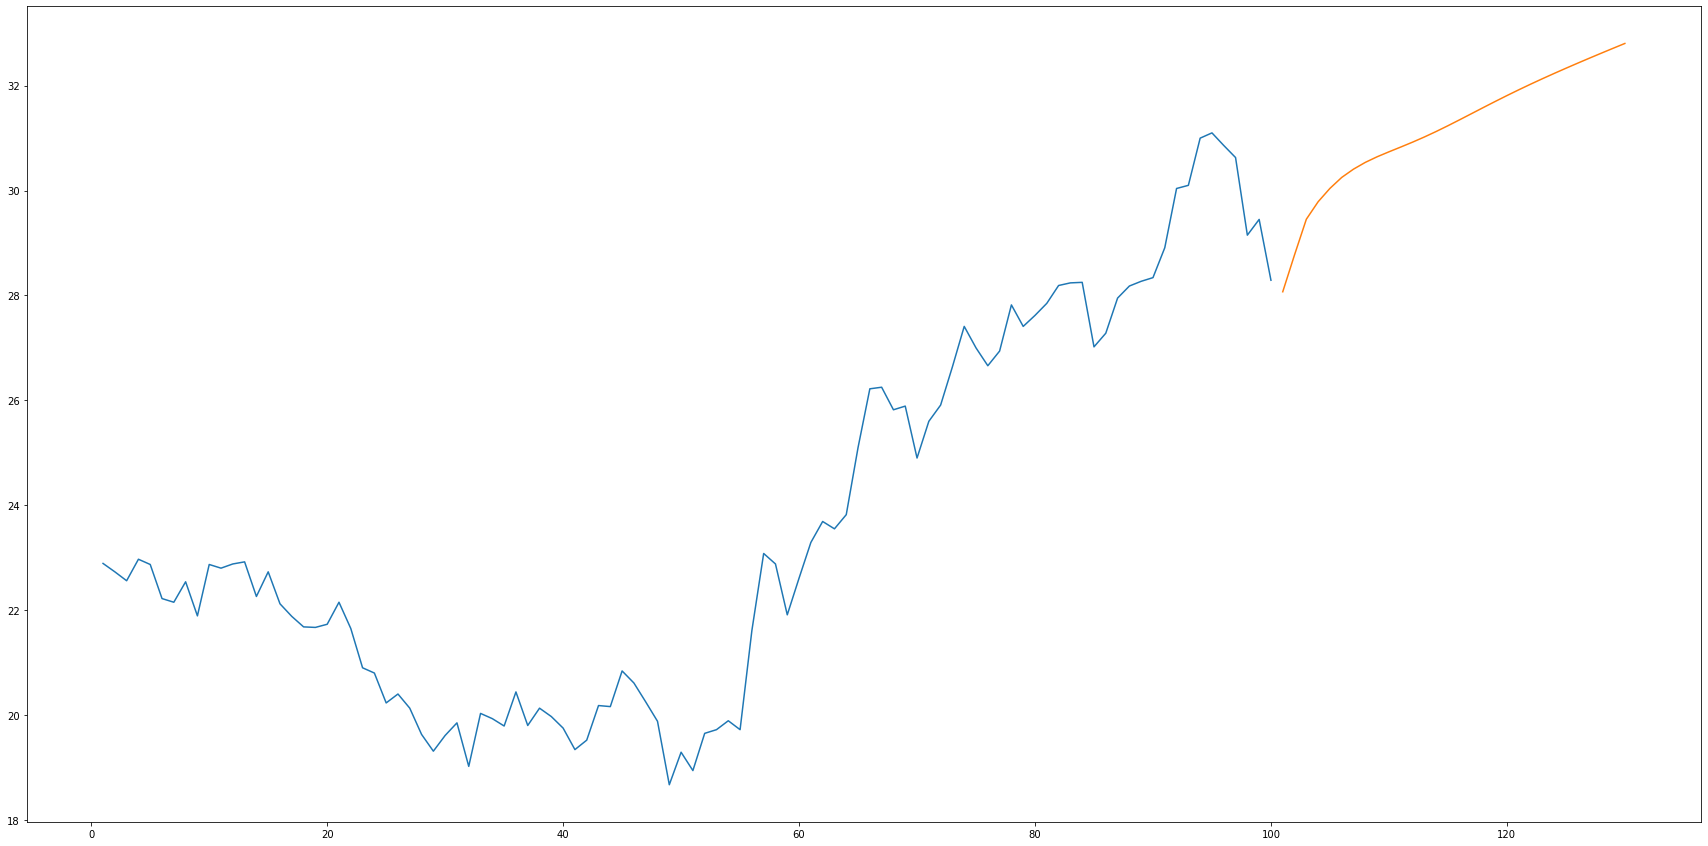

In [143]:
plt.figure(figsize=(30, 15))
plt.plot(time_new,scaler.inverse_transform(df1[(len(df1)-n_steps):]))
plt.plot(time_pred,scaler.inverse_transform(lst_output))
plt.show()

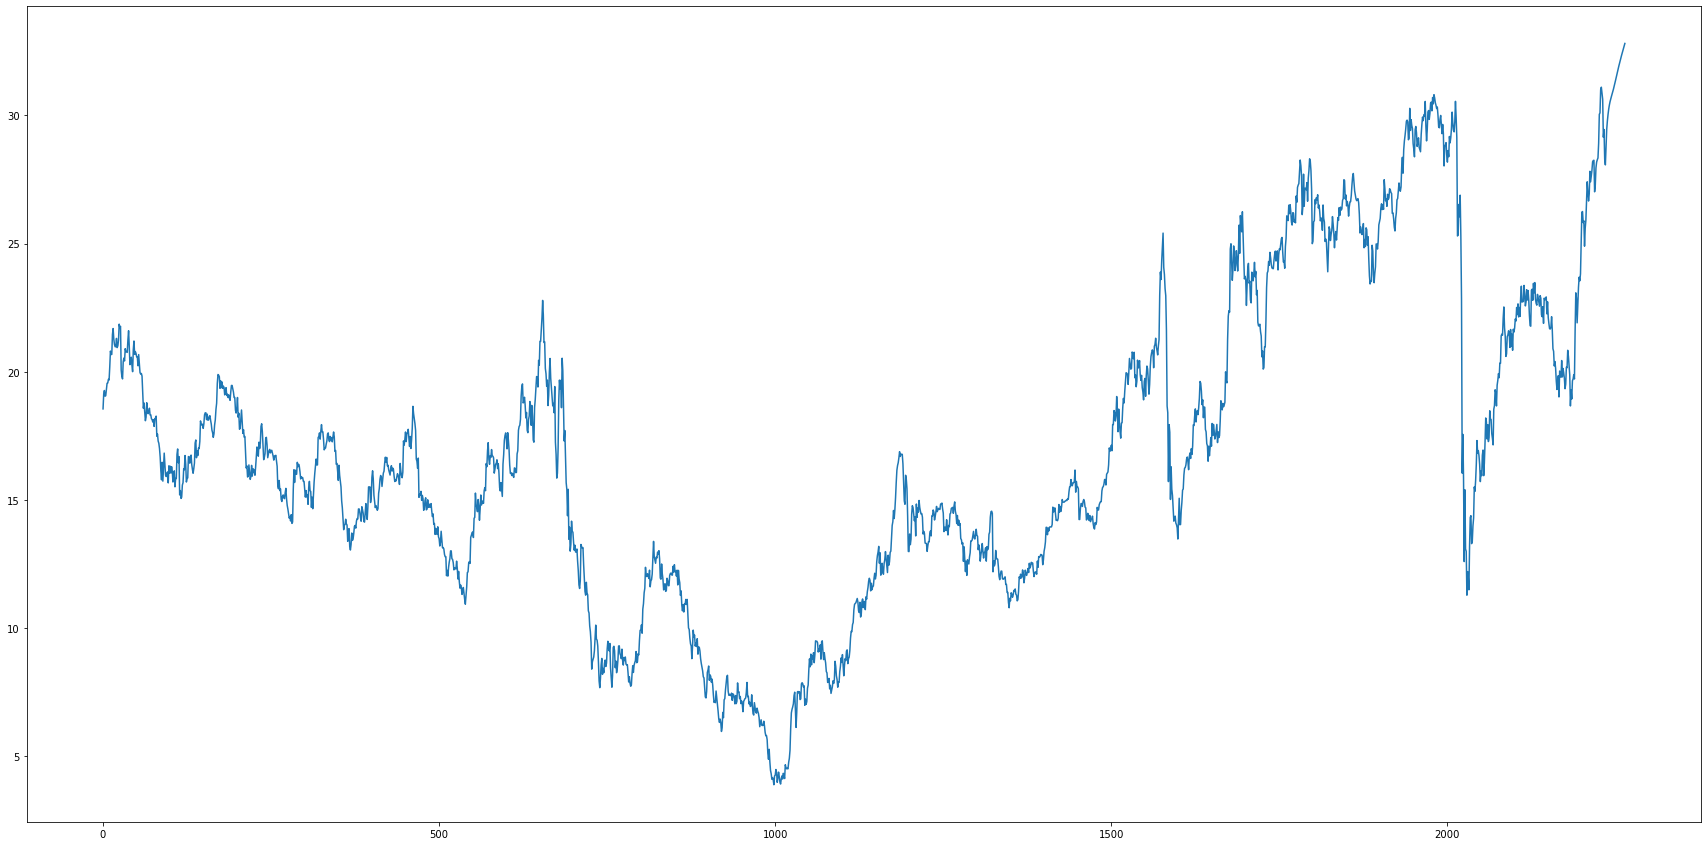

In [144]:
#extend prediction on the graph

df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()

plt.figure(figsize=(30, 15))
plt.plot(df3)
plt.show()

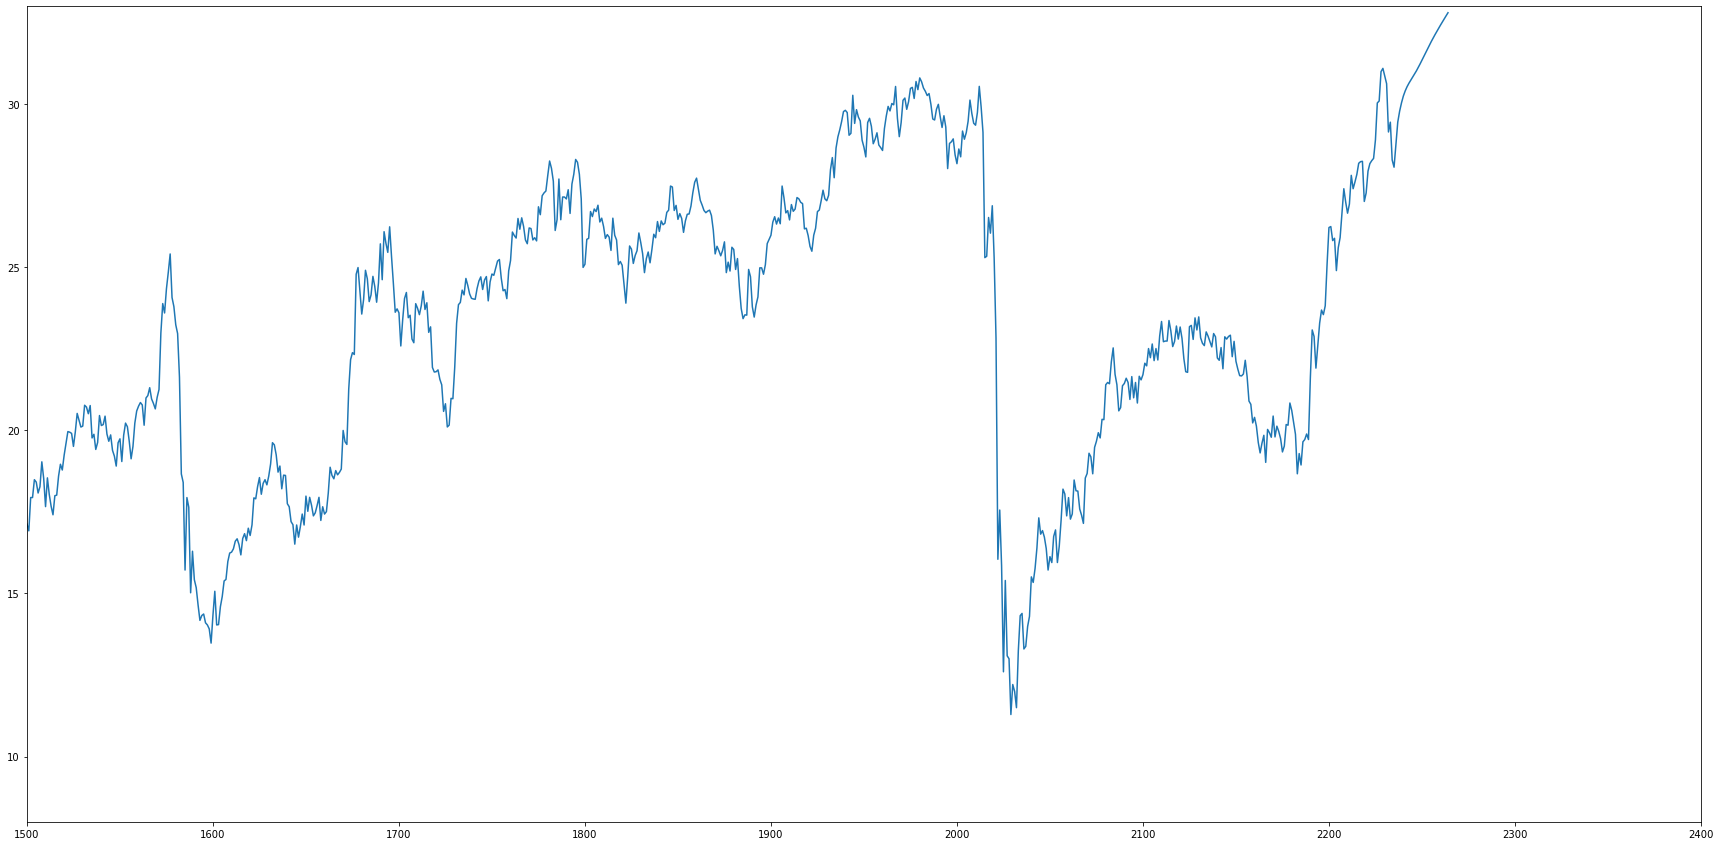

In [145]:
plt.figure(figsize=(30, 15))
#adjust zoom in to the stock/security axis
plt.axis([1500,2400,8,33])
plt.plot(df3)
plt.show()